<a href="https://colab.research.google.com/github/fhun/bus-arrival-time-neural-network-ga-kalman/blob/master/1_1_MLP_KF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

Route 101 ***U Wandsbek Markt to S Rübenkamp***

In [3]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed.csv"
df_proceeded = pd.read_csv(path)

In [4]:
df_proceeded

,Unnamed: 0,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday,Actual_trip_cum,Planned_trip_cum
0,0,2019-01-02 09:47:00,U Wandsbek Markt|Wandsbeker Allee,0.0,180.0,204.0,2,1,1,204,180
1,1,2019-01-02 09:50:00,Wandsbeker Allee|U Straßburger Straße,0.0,120.0,108.0,2,1,1,312,300
2,2,2019-01-02 09:52:00,U Straßburger Straße|U Alter Teichweg,0.0,120.0,96.0,2,1,1,408,420
3,3,2019-01-02 09:54:00,U Alter Teichweg|Habichtstraße (Mitte),0.0,180.0,168.0,2,1,1,576,600
4,4,2019-01-02 09:57:00,Habichtstraße (Mitte)|U Habichtstraße,0.0,60.0,54.0,2,1,1,630,660
...,...,...,...,...,...,...,...,...,...,...,...
132959,132959,2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1.0,180.0,144.0,0,12,1,864,900
132960,132960,2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1.0,60.0,66.0,0,12,1,930,960
132961,132961,2019-12-23 09:02:00,Hartzloh|AK Barmbek,1.0,60.0,60.0,0,12,1,990,1020
132962,132962,2019-12-23 09:03:00,AK Barmbek|Hebebrandstraße,1.0,120.0,132.0,0,12,1,1122,1140


In [5]:
#df_proceeded = df_proceeded.sort_values(by=['Time']) #no sort because when sort out the sequence of the trips switch. And when train and test is not split with percentage, there is no problem with unsorted data.

In [6]:
#df_proceeded['Time']

Route 102 ***S Rübenkamp to U Wandsbek Markt***

In [7]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed102.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed102.csv"
df_proceeded102 = pd.read_csv(path)
#df_proceeded102 = df_proceeded102.sort_values(by=['Time'])

Route 201 ***U Wandsbek Markt to Lufthansa-Basis (Haupteingang)***

In [8]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed201.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed201.csv"
df_proceeded201 = pd.read_csv(path)
#df_proceeded201 = df_proceeded201.sort_values(by=['Time'])

Route 202 ***Lufthansa-Basis (Haupteingang) to U Wandsbek Markt***

In [9]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed202.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed202.csv"
df_proceeded202 = pd.read_csv(path)
#df_proceeded202 = df_proceeded202.sort_values(by=['Time'])

# Preprocessing

Route 101 ***U Wandsbek Markt to S Rübenkamp***



In [10]:
data = df_proceeded[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
data.head()

,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,
2019-01-02 09:47:00,U Wandsbek Markt|Wandsbeker Allee,0,2,1,204.0
2019-01-02 09:50:00,Wandsbeker Allee|U Straßburger Straße,0,2,1,108.0
2019-01-02 09:52:00,U Straßburger Straße|U Alter Teichweg,0,2,1,96.0
2019-01-02 09:54:00,U Alter Teichweg|Habichtstraße (Mitte),0,2,1,168.0
2019-01-02 09:57:00,Habichtstraße (Mitte)|U Habichtstraße,0,2,1,54.0


In [12]:
data.loc[data.Precipitation == -499 ]=0
#df.Num_of_employees = df.Num_of_employees.replace({"10-Jan": "1-10","Nov-50": "11-50"})
#data.Precipitation = data.Precipitation.replace({-449:0})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
data.loc[data.Precipitation == -499 ]

,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [14]:
#data = data.loc[data['dayofweek'].isin([1])] #select Mondays

In [15]:
data = data.loc[data['Node A to Node B'].isin(['U Wandsbek Markt|Wandsbeker Allee',
       'Wandsbeker Allee|U Straßburger Straße',
       'U Straßburger Straße|U Alter Teichweg',
       'U Alter Teichweg|Habichtstraße (Mitte)',
       'Habichtstraße (Mitte)|U Habichtstraße',
       'U Habichtstraße|Habichtsplatz', 'Habichtsplatz|Neue Wöhr',
       'Neue Wöhr|Hartzloh', 'Hartzloh|AK Barmbek',
       'AK Barmbek|Hebebrandstraße', 'Hebebrandstraße|S Rübenkamp'])]
df_proceeded = data

In [16]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [17]:
data.dtypes

Node A to Node B    category
Precipitation       category
dayofweek           category
timeofday           category
Driving_time_s       float64
dtype: object

## One-hot encoding

One-hot encode the categorical feautures.



In [18]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head() #[:50]

,Driving_time_s,Node A to Node B_AK Barmbek|Hebebrandstraße,Node A to Node B_Habichtsplatz|Neue Wöhr,Node A to Node B_Habichtstraße (Mitte)|U Habichtstraße,Node A to Node B_Hartzloh|AK Barmbek,Node A to Node B_Hebebrandstraße|S Rübenkamp,Node A to Node B_Neue Wöhr|Hartzloh,Node A to Node B_U Alter Teichweg|Habichtstraße (Mitte),Node A to Node B_U Habichtstraße|Habichtsplatz,Node A to Node B_U Straßburger Straße|U Alter Teichweg,Node A to Node B_U Wandsbek Markt|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Straßburger Straße,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4
Time,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 09:47:00,204.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:50:00,108.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:52:00,96.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:54:00,168.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:57:00,54.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [19]:
data.describe

<bound method NDFrame.describe of                      Driving_time_s  ...  timeofday_4
Time                                 ...             
2019-01-02 09:47:00           204.0  ...            0
2019-01-02 09:50:00           108.0  ...            0
2019-01-02 09:52:00            96.0  ...            0
2019-01-02 09:54:00           168.0  ...            0
2019-01-02 09:57:00            54.0  ...            0
...                             ...  ...          ...
2019-12-23 08:58:00           144.0  ...            0
2019-12-23 09:01:00            66.0  ...            0
2019-12-23 09:02:00            60.0  ...            0
2019-12-23 09:03:00           132.0  ...            0
2019-12-23 09:05:00            60.0  ...            0

[132964 rows x 26 columns]>

In [20]:
data101 = data.copy()
#data101

# Preprocessing with other journeys

Journey 102 ***S Rübenkamp to U Wandsbek Markt***

In [21]:
data = df_proceeded102[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded102['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [23]:
data = data.loc[data['Node A to Node B'].isin(['U Straßburger Straße|Wandsbeker Allee',
'AK Barmbek|Hartzloh',
'U Habichtstraße|Habichtstraße (Mitte)',
'Habichtsplatz|U Habichtstraße',
'U Alter Teichweg|U Straßburger Straße',
'Wandsbeker Allee|U Wandsbek Markt',
'Hartzloh|Habichtsplatz',
'S Rübenkamp|AK Barmbek',
'Habichtstraße (Mitte)|U Alter Teichweg'])]
df_proceeded102 = data

In [24]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [25]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
#data[:50]

In [26]:
data102 = data.copy()
data102.head()

,Driving_time_s,Node A to Node B_AK Barmbek|Hartzloh,Node A to Node B_Habichtsplatz|U Habichtstraße,Node A to Node B_Habichtstraße (Mitte)|U Alter Teichweg,Node A to Node B_Hartzloh|Habichtsplatz,Node A to Node B_S Rübenkamp|AK Barmbek,Node A to Node B_U Alter Teichweg|U Straßburger Straße,Node A to Node B_U Habichtstraße|Habichtstraße (Mitte),Node A to Node B_U Straßburger Straße|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Wandsbek Markt,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4
Time,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 10:25:00,186.0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 10:28:00,90.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 10:29:00,138.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 10:32:00,78.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 10:33:00,90.0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


Journey 201 ***U Wandsbek Markt to Lufthansa-Basis (Haupteingang)***

In [27]:
data = df_proceeded201[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded201['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [29]:
data = data.loc[data['Node A to Node B'].isin(['Kapstadtring|Manilabrücke',
'U Alsterdorf|Hindenburgstraße',
'Habichtstraße (Mitte)|U Habichtstraße',
'Neue Wöhr|Hartzloh',
'Hartzloh|AK Barmbek',
'Brabandstraße|Moltrechtweg',
'Alsterkrugchaussee (Mitte)|Obenhauptstraße',
'Manilabrücke|Sydneystraße',
'Hebebrandstraße|S Rübenkamp',
'U Habichtstraße|Habichtsplatz',
'Moltrechtweg|Alsterkrugchaussee (Mitte)',
'Hindenburgstraße|Brabandstraße',
'S Rübenkamp|Kapstadtring',
'Wandsbeker Allee|U Straßburger Straße',
'Sydneystraße|U Alsterdorf',
'Habichtsplatz|Neue Wöhr',
'AK Barmbek|Hebebrandstraße',
'U Straßburger Straße|U Alter Teichweg',
'Obenhauptstraße|Lufthansa-Basis (Haupteingang)',
'U Alter Teichweg|Habichtstraße (Mitte)',
'U Wandsbek Markt|Wandsbeker Allee',
])]
df_proceeded201 = data

In [30]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [31]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
#data.head() #[:50]

In [32]:
data201 = data.copy()
data201.head()

,Driving_time_s,Node A to Node B_AK Barmbek|Hebebrandstraße,Node A to Node B_Alsterkrugchaussee (Mitte)|Obenhauptstraße,Node A to Node B_Brabandstraße|Moltrechtweg,Node A to Node B_Habichtsplatz|Neue Wöhr,Node A to Node B_Habichtstraße (Mitte)|U Habichtstraße,Node A to Node B_Hartzloh|AK Barmbek,Node A to Node B_Hebebrandstraße|S Rübenkamp,Node A to Node B_Hindenburgstraße|Brabandstraße,Node A to Node B_Kapstadtring|Manilabrücke,Node A to Node B_Manilabrücke|Sydneystraße,Node A to Node B_Moltrechtweg|Alsterkrugchaussee (Mitte),Node A to Node B_Neue Wöhr|Hartzloh,Node A to Node B_Obenhauptstraße|Lufthansa-Basis (Haupteingang),Node A to Node B_S Rübenkamp|Kapstadtring,Node A to Node B_Sydneystraße|U Alsterdorf,Node A to Node B_U Alsterdorf|Hindenburgstraße,Node A to Node B_U Alter Teichweg|Habichtstraße (Mitte),Node A to Node B_U Habichtstraße|Habichtsplatz,Node A to Node B_U Straßburger Straße|U Alter Teichweg,Node A to Node B_U Wandsbek Markt|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Straßburger Straße,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4,timeofday_5
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 10:57:00,186.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:00:00,84.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:02:00,102.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:04:00,162.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:07:00,36.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


Journey 202 ***Lufthansa-Basis (Haupteingang) to U Wandsbek Markt***

In [33]:
data = df_proceeded202[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded202['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [35]:
data = data.loc[data['Node A to Node B'].isin(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
        'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
        'Alsterkrugchaussee (Mitte)|Moltrechtweg',
        'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
        'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
        'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
        'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
        'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
        'U Habichtstraße|Habichtstraße (Mitte)',
        'Habichtstraße (Mitte)|U Alter Teichweg',
        'U Alter Teichweg|U Straßburger Straße',
        'U Straßburger Straße|Wandsbeker Allee',
        'Wandsbeker Allee|U Wandsbek Markt'])]
df_proceeded202 = data

In [36]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [37]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
#data[:50]

In [38]:
data202 = data.copy()
data202.head()

,Driving_time_s,Node A to Node B_AK Barmbek|Hartzloh,Node A to Node B_Alsterkrugchaussee (Mitte)|Moltrechtweg,Node A to Node B_Brabandstraße|Hindenburgstraße,Node A to Node B_Habichtsplatz|U Habichtstraße,Node A to Node B_Habichtstraße (Mitte)|U Alter Teichweg,Node A to Node B_Hartzloh|Habichtsplatz,Node A to Node B_Hindenburgstraße|U Alsterdorf,Node A to Node B_Kapstadtring|S Rübenkamp,Node A to Node B_Lufthansa-Basis (Haupteingang)|Obenhauptstraße,Node A to Node B_Manilabrücke|Kapstadtring,Node A to Node B_Moltrechtweg|Brabandstraße,Node A to Node B_Obenhauptstraße|Alsterkrugchaussee (Mitte),Node A to Node B_S Rübenkamp|AK Barmbek,Node A to Node B_Sydneystraße|Manilabrücke,Node A to Node B_U Alsterdorf|Sydneystraße,Node A to Node B_U Alter Teichweg|U Straßburger Straße,Node A to Node B_U Habichtstraße|Habichtstraße (Mitte),Node A to Node B_U Straßburger Straße|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Wandsbek Markt,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4,timeofday_5
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 11:40:00,186.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:42:00,30.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:43:00,60.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:45:00,96.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2019-01-02 11:46:00,138.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


# Select journey (route) to implement

In [39]:
#select the route one by one
route = 202
month = 4

if route == 101:
  #route 101
  data = data101.copy()
  df_proceeded_month = df_proceeded.loc[pd.to_datetime(df_proceeded.index).month == month]
  df_proceeded_node = df_proceeded_month['Node A to Node B']
  path_end = "data101"
  path_name = "Route 101 U Wandsbek Markt to S Rübenkamp"
  route_unique = (df_proceeded_node.unique())

elif route == 102:
  #route 102
  data = data102.copy()
  df_proceeded_month = df_proceeded102.loc[pd.to_datetime(df_proceeded102.index).month == month]
  df_proceeded_node = df_proceeded_month['Node A to Node B']
  path_end = "data102"
  path_name = "Route 102 S Rübenkamp to U Wandsbek Markt"
  route_unique = (df_proceeded_node.unique())

elif route == 201:
  #route 201
  data = data201.copy()
  df_proceeded_month = df_proceeded201.loc[pd.to_datetime(df_proceeded201.index).month == month]
  df_proceeded_node = df_proceeded_month['Node A to Node B']
  path_end = "data201"
  path_name = "Route 201 U Wandsbek Markt to Lufthansa-Basis (Haupteingang)"
  route_unique = (df_proceeded_node.unique())

elif route ==202:
  #route 202
  data = data202.copy()
  df_proceeded_month = df_proceeded202.loc[pd.to_datetime(df_proceeded202.index).month == month]
  df_proceeded_node = df_proceeded_month['Node A to Node B']
  path_end = "data202"
  path_name = "Route 202 Lufthansa-Basis (Haupteingang) to U Wandsbek Markt"
  route_unique = np.array(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
        'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
        'Alsterkrugchaussee (Mitte)|Moltrechtweg',
        'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
        'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
        'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
        'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
        'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
        'U Habichtstraße|Habichtstraße (Mitte)',
        'Habichtstraße (Mitte)|U Alter Teichweg',
        'U Alter Teichweg|U Straßburger Straße',
        'U Straßburger Straße|Wandsbeker Allee',
        'Wandsbeker Allee|U Wandsbek Markt'], dtype= object)

In [40]:
data = data.loc[pd.to_datetime(data.index).month == month] #filter only a particular month

In [41]:
len(route_unique)

19

# The train, validation and test dataset

Get the X_train, X_val and X_test on datetime values.

In [42]:
s =pd.to_datetime(data.index).month #create new vectors for collecting index to use in spliting the data.
d = pd.to_datetime(data.index).day

In [43]:
#np.where((s == 2))[0][0]

In [44]:
from sklearn.model_selection import train_test_split


#Split with week number
s =pd.to_datetime(data.index).day.tolist()

split_index_val = s.index(16) #validation set is cover on 3th week
split_index_test = s.index(23) #test set covers last week

'''
#Split with month and first week
s =pd.to_datetime(data.index).month
d = pd.to_datetime(data.index).day

split_index_val = np.where((s == 1)& (d == 18))[0][0]
split_index_test = np.where((s == 1)& (d == 25))[0][0] # & (d == 11)
split_index_end = np.where((s == 2) )[0][0]
'''
train = data[:split_index_val]
val = data[split_index_val:split_index_test]
test = data[split_index_test:] #split_index_end


#for plotting graph
date_time = pd.to_datetime(data.index)
date_time_train = date_time[:split_index_val]
date_time_val = date_time[split_index_val:split_index_test]
date_time_test = date_time[split_index_test:] #split_index_end

'''
#Split with percentage
train_size = 0.7
val_size= 0.2 # The validation size of the train set

# Split train & test
split_index_val = int(data.shape[0]*(train_size-val_size)) # the index at which to split df into train and test
split_index_test = int(data.shape[0]*train_size) # the index at which to split df into train and test
'''

'''
X = data.drop(['Driving_time_s'], axis=1)

y = data['Driving_time_s']

X_train = X[:split_index_val]
X_val = X[split_index_val:split_index_test]
X_test = X[split_index_test:]

y_train = y[:split_index_val]
y_val = y[split_index_val:split_index_test]
y_test = y[split_index_test:]
'''

"\nX = data.drop(['Driving_time_s'], axis=1)\n\ny = data['Driving_time_s']\n\nX_train = X[:split_index_val]\nX_val = X[split_index_val:split_index_test]\nX_test = X[split_index_test:]\n\ny_train = y[:split_index_val]\ny_val = y[split_index_val:split_index_test]\ny_test = y[split_index_test:]\n"

## Feature scaling

"It is a step of Data Pre Processing which is applied to independent variables or features of data. It basically helps to normalise the data within a particular range. Sometimes, it also helps in speeding up the calculations in an algorithm." https://www.geeksforgeeks.org/python-how-and-where-to-apply-feature-scaling/

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit scaler
scaler.fit(train)
# transform training dataset
train = scaler.transform(train)
# transform validation dataset
val = scaler.transform(val)
# transform test dataset
test = scaler.transform(test)

In [46]:
'''
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train) #Feature scaling

X_train = scalerX.transform(X_train)
X_val = scalerX.transform(X_val)
X_test = scalerX.transform(X_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\nscalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train) #Feature scaling\n\nX_train = scalerX.transform(X_train)\nX_val = scalerX.transform(X_val)\nX_test = scalerX.transform(X_test)\n'

In [47]:
X_train = train[:,1:]
X_val = val[:,1:]
X_test = test[:,1:]

y_train = train[:,0]
y_val = val[:,0]
y_test = test[:,0]

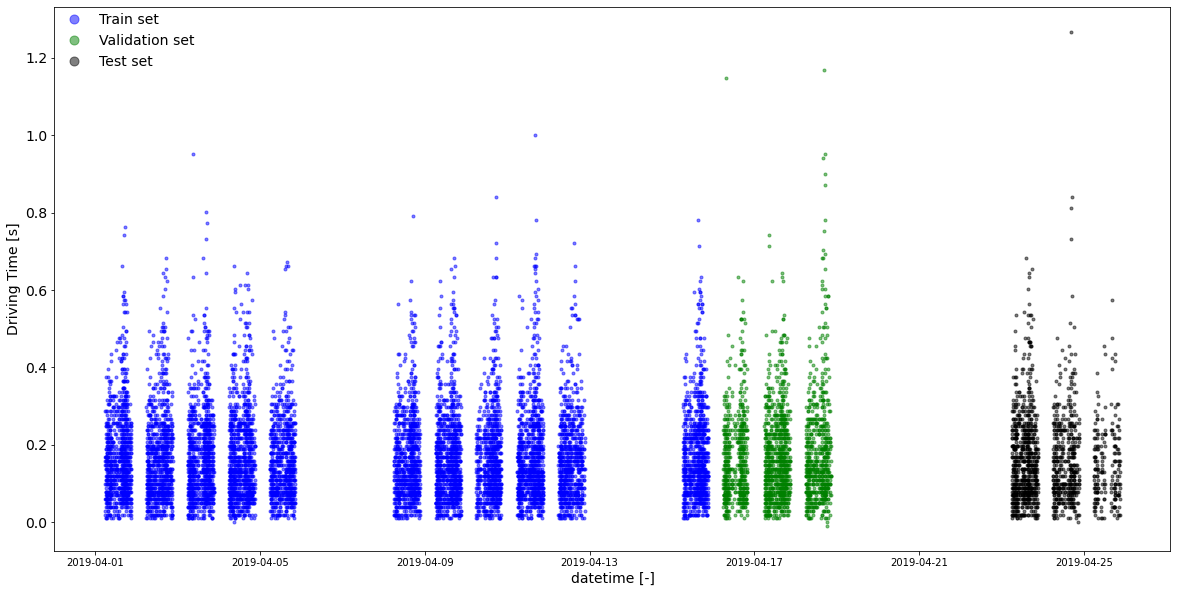

In [48]:
plt.figure(figsize=(20,10))

plt.plot(date_time_train, y_train, '.', color='blue', label='Train set', alpha=0.5)
plt.plot(date_time_val, y_val, '.', color='green', label='Validation set', alpha=0.5)
plt.plot(date_time_test, y_test, '.', color='black', label='Test set', alpha=0.5)

plt.ylabel(r'Driving Time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

#plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

#plt.savefig('Train Val Test plot.png', dpi=1300)

In [49]:
print((X_train.shape, y_train.shape))
print((X_val.shape, y_val.shape))
print((X_test.shape, y_test.shape))

((9994, 32), (9994,))
((2065, 32), (2065,))
((1441, 32), (1441,))


In [50]:
!pip install ipython-autotime

%load_ext autotime

time: 330 µs (started: 2021-02-10 00:13:37 +00:00)


# MLP model

In [ ]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
keras.backend.clear_session()

# to make output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

time: 17.9 ms (started: 2021-01-14 13:59:47 +00:00)


In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint1 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/MLP.best_mse_"+path_end+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/MLP.best_rmse_"+path_end+".hdf5", monitor='val_root_mean_squared_error', verbose=1, save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/MLP.best_mae_"+path_end+".hdf5", monitor='val_mae', verbose=1, save_best_only=True, mode='min')

time: 5.45 ms (started: 2021-01-14 13:59:47 +00:00)


In [ ]:
#structure the model
model = keras.models.Sequential()
#Hidden Layer 1
model.add(keras.layers.Dense(4, input_shape=(X_train.shape[1],), kernel_initializer='TruncatedNormal', use_bias=False, activation='relu'))
model.add(BatchNormalization())
#model.add(LeakyReLU())
model.add(keras.layers.Dropout(0.2))
#Layer output
model.add(keras.layers.Dense(1))

model.compile(loss="mean_squared_error", optimizer='adam', metrics=['RootMeanSquaredError', 'mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[callback, checkpoint1, checkpoint2, checkpoint3],
                   validation_data=(X_val, y_val))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 128       
_________________________________________________________________
batch_normalization (BatchNo (None, 4)                 16        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 149
Trainable params: 141
Non-trainable params: 8
_________________________________________________________________
time: 4.17 ms (started: 2021-01-14 14:02:34 +00:00)


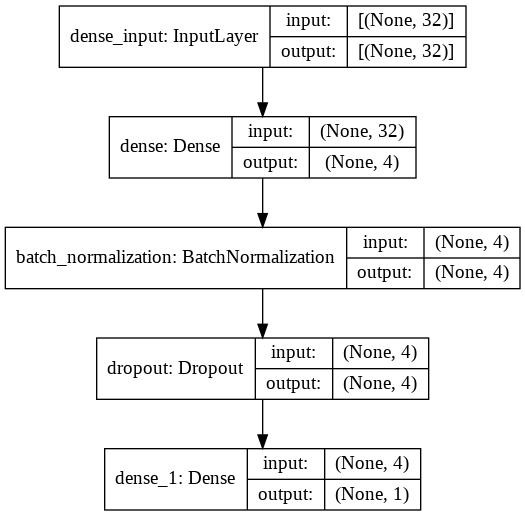

time: 102 ms (started: 2021-01-14 14:02:34 +00:00)


In [ ]:
keras.utils.plot_model(model, "my_hb_model.png", show_shapes=True)

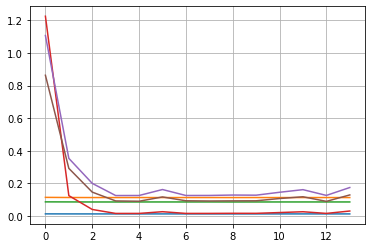

time: 179 ms (started: 2021-01-14 14:02:35 +00:00)


In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

# Cross validate on the test set

In [ ]:
%time
from keras.models import load_model

# Load the architecture
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/best model/MLP.best_mse_'+path_end+'.hdf5') # Gave an error when loading without 'custom_objects'.. fixed by https://github.com/keras-team/keras/issues/3911

# Compile with the same settings as it has been saved with earlier
model.compile(loss="mean_squared_error", optimizer='adam', metrics=['RootMeanSquaredError', 'mae'])

print('FINISHED')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
FINISHED
time: 1.18 s (started: 2021-01-14 14:02:35 +00:00)


In [ ]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

time: 110 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
model.evaluate(X_test, y_test)

46/46 [==============================] - 0s 1ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - mae: 0.0900


[0.013320596888661385, 0.11541488766670227, 0.08805455267429352]

time: 282 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
# invert scaling for prediction
inv_y_pred = np.concatenate((y_pred, X_test[:, :]), axis=1)
inv_y_pred = scaler.inverse_transform(inv_y_pred)
inv_y_pred = inv_y_pred[:,0]

time: 4.64 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
# invert scaling for actual
inv_y_true = np.concatenate((y_true, X_test[:,:]), axis=1)
inv_y_true = scaler.inverse_transform(inv_y_true)
inv_y_true = inv_y_true[:,0]

time: 4.06 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
# calculate RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(inv_y_true, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y_true, inv_y_pred))
mae = mean_absolute_error(inv_y_true, inv_y_pred)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test MSE: 4891.803
Test RMSE: 69.941
Test MAE: 53.361
time: 7.66 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
#collect all in a new dataframe
comb_result = pd.DataFrame({'Date time': date_time_test, 'Path': df_proceeded_node[split_index_test:], 'Actual': inv_y_true, 'MLP': inv_y_pred}).reset_index()
comb_result.sort_values(by=['Date time'])

,Time,Date time,Path,Actual,MLP
491,2019-04-23 05:50:00,2019-04-23 05:50:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,192.0,119.699430
492,2019-04-23 05:52:00,2019-04-23 05:52:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),30.0,119.366318
493,2019-04-23 05:53:00,2019-04-23 05:53:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,84.0,119.072126
494,2019-04-23 05:55:00,2019-04-23 05:55:00,Moltrechtweg|Brabandstraße,66.0,117.825141
495,2019-04-23 05:56:00,2019-04-23 05:56:00,Brabandstraße|Hindenburgstraße,90.0,118.010159
...,...,...,...,...,...
1284,2019-04-25 20:41:00,2019-04-25 20:41:00,U Habichtstraße|Habichtstraße (Mitte),54.0,125.380430
1285,2019-04-25 20:42:00,2019-04-25 20:42:00,Habichtstraße (Mitte)|U Alter Teichweg,114.0,124.931372
1286,2019-04-25 20:45:00,2019-04-25 20:45:00,U Alter Teichweg|U Straßburger Straße,72.0,123.481138
1287,2019-04-25 20:46:00,2019-04-25 20:46:00,U Straßburger Straße|Wandsbeker Allee,30.0,125.380421


time: 43.2 ms (started: 2021-01-14 14:02:36 +00:00)


Show in the graph only first 50 points.

46/46 [==============================] - 0s 896us/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - mae: 0.0881
FINISHED


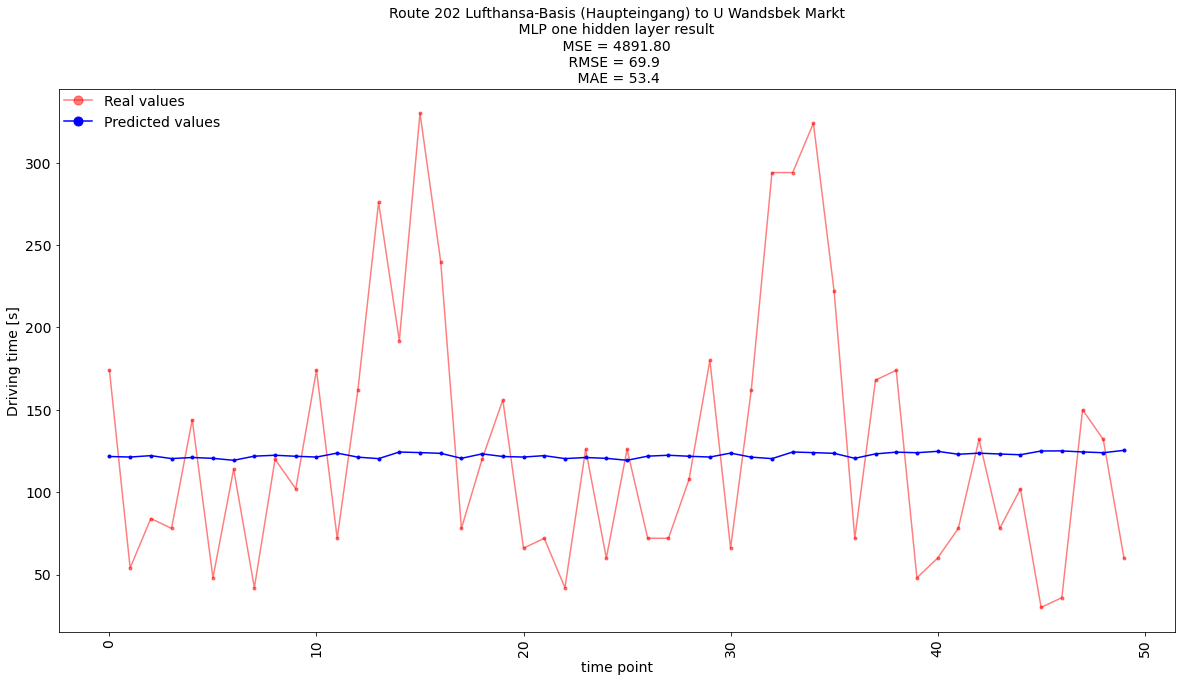

time: 463 ms (started: 2021-01-14 14:02:36 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(  inv_y_true[:50], '.-', color='red', label='Real values', alpha=0.5)
plt.plot(  inv_y_pred[:50], '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Driving time [s]', fontsize=14)
plt.xlabel('time point', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, rmse_result, mae_result = model.evaluate(X_test, y_test)

plt.title(path_name+'\n MLP one hidden layer result \n MSE = %.2f \n RMSE = %.1f  \n MAE = %.1f' % (mse, rmse, mae), fontsize = 14)

print('FINISHED')

In [ ]:
comb_result.sort_values(by=['Date time'])['MLP']

491     119.699430
492     119.366318
493     119.072126
494     117.825141
495     118.010159
           ...    
1284    125.380430
1285    124.931372
1286    123.481138
1287    125.380421
1288    125.380412
Name: MLP, Length: 1441, dtype: float64

time: 6.42 ms (started: 2021-01-14 14:02:37 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot( comb_result.sort_values(by=['Date time'])['Date time'], comb_result.sort_values(by=['Date time'])['Actual'], '.-', color='red', label='Real values', alpha=0.5)
plt.plot( comb_result.sort_values(by=['Date time'])['Date time'], comb_result.sort_values(by=['Date time'])['MLP'], '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Driving time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, rmse_result, mae_result = model.evaluate(X_test, y_test)

plt.title(path_name+'\n MLP one hidden layer result \n MSE = %.2f \n RMSE = %.1f  \n MAE = %.1f' % (mse, rmse, mae), fontsize = 14)

print('FINISHED')

# Kalman filter
Fine-tune the estimation travel time from MLP with the most recent bus arrival time information

In the following are based on Chen et al. (2004).
Consider the following state space model:

 $X_{k+1} =
 \begin{pmatrix}
  1 & 0 \\
  0 & 1 
 \end{pmatrix}
 X_k+u_k+w_k$

 $z_k = HX_k + v_k$

The filtering procedure is outlined as follows.





1.   set $\hat X^-_0 = \begin{pmatrix}
  \hat t_0 \\ \hat s_0 
 \end{pmatrix}  =  \begin{pmatrix}
  \hat t_0 \\ 0 
 \end{pmatrix} $ 
 ; $t_0$ is the total travel time predicted from MLP of that trip. $s_0$ is the travel time predicted from MLP from the origin to the time point $k$ therefore $s_0$ is zero.
2.   set covariance matrix $p_0 = \begin{pmatrix}
  1 & 0 \\
  0 & 1 
 \end{pmatrix} $

3. predict State variable $ \hat X^-_k = F \hat X_{k-1} + T_{k-1, k} \begin{pmatrix}
  -1 \\ 1
 \end{pmatrix}
 = \begin{pmatrix}
  1 & 0 \\ 0 & 1
 \end{pmatrix}
  \hat X_{k-1} + T_{k-1, k} \begin{pmatrix}
  -1 \\ 1
 \end{pmatrix}$
 ; $T_{k-1, k}$ is the travel time predicted from MLP from node $k-1$ to $k$

4. calculate Covariance $P^-_k = F P_{k-1} F^T + Q_{k-1}$ where $Q_{k-1}$ is the process noise.

5. calculate Kalman gain $K_k = P^-_kH (HP^-_kH^T + R)^{-1}$ where $ H = \begin{pmatrix}
  0 & 1
 \end{pmatrix} $ and $R$ is the measure noise

6. update State variable $\hat X_k = \hat X^-_k  +K_k(z_k - H \hat X^-_k) $ ; $z_k$ is the actual driving time from the original $k = 0$ to time point $k$

7. if $k$ is the destination time point, finish the process. Otherwise continue.

8. update Covariance $P_k = P^-_k - K_k H P^-_k$

9. repeat from 3.




## Run Kalman filter without spliting by tour

### Preparing data

In [ ]:
s =[] # list of the accumulate estimation travel time from origin to time point k.
a = 0
for i in range(len(inv_y_true)):
  a = inv_y_pred[i]+a
  s.append(a)
s

[121.64845114946365,
 242.96378177404404,
 365.1226685643196,
 485.4998255968094,
 606.5388982594013,
 727.0693683922291,
 846.4161093235016,
 968.2722167372704,
 1090.6833414137363,
 1212.4707026481628,
 1333.7862229049206,
 1457.4943684637547,
 1578.7480596005917,
 1699.1013681292534,
 1823.4724226295948,
 1947.4840338528156,
 2071.0477699935436,
 2191.6004000008106,
 2314.8367768228054,
 2436.485227972269,
 2557.8005585968494,
 2679.959445387125,
 2800.336602419615,
 2921.3756750822067,
 3041.9061452150345,
 3161.252886146307,
 3283.1089935600758,
 3405.5201182365417,
 3527.3074794709682,
 3648.622999727726,
 3772.33114528656,
 3893.584836423397,
 4013.938144952059,
 4138.3091994524,
 4262.320810675621,
 4385.884546816349,
 4506.437176823616,
 4629.673553645611,
 4753.949620485306,
 4877.892575830221,
 5002.679060250521,
 5125.683832973242,
 5249.350521326065,
 5372.508616179228,
 5495.211467385292,
 5620.205824792385,
 5745.244556128979,
 5869.659551113844,
 5993.602696090937,
 611

time: 51 ms (started: 2021-01-14 14:02:38 +00:00)


In [ ]:
t = [s[len(s)-1]] #the total estimation travel time from time point k to the given destination
a = s[len(s)-1]
for i in range(len(s)):
  a = a - inv_y_pred[i]
  t.append(a)
t = t[:-1]
t

[177047.79522317648,
 176926.14677202702,
 176804.83144140244,
 176682.67255461216,
 176562.29539757967,
 176441.25632491708,
 176320.72585478425,
 176201.37911385298,
 176079.5230064392,
 175957.11188176274,
 175835.32452052832,
 175714.00900027156,
 175590.30085471272,
 175469.0471635759,
 175348.69385504723,
 175224.32280054688,
 175100.31118932366,
 174976.74745318294,
 174856.19482317567,
 174732.95844635367,
 174611.3099952042,
 174489.99466457963,
 174367.83577778935,
 174247.45862075686,
 174126.41954809427,
 174005.88907796144,
 173886.54233703017,
 173764.6862296164,
 173642.27510493994,
 173520.4877437055,
 173399.17222344875,
 173275.46407788992,
 173154.21038675308,
 173033.85707822442,
 172909.48602372408,
 172785.47441250086,
 172661.91067636013,
 172541.35804635286,
 172418.12166953087,
 172293.84560269117,
 172169.90264734626,
 172045.11616292596,
 171922.11139020324,
 171798.4447018504,
 171675.28660699725,
 171552.5837557912,
 171427.5893983841,
 171302.5506670475,
 

time: 40.2 ms (started: 2021-01-14 14:02:38 +00:00)


In [ ]:
Tk_k1 = inv_y_pred[:] #the estimation travel time from time point k to time point k + 1
Tk_k1

array([121.64845115, 121.31533062, 122.15888679, ..., 124.03858414,
       125.3804124 , 125.3804124 ])

time: 6.91 ms (started: 2021-01-14 14:02:38 +00:00)


In [ ]:
z_act = inv_y_true[:] # the observed (actual) travel time from time point k to time point k + 1 
z_act

array([174.,  54.,  84., ..., 180.,  78., 186.])

time: 5.06 ms (started: 2021-01-14 14:02:38 +00:00)


In [ ]:
z_s =[] # the accumulate observed travel time from origin to time point k.
a = 0
for i in range(len(inv_y_true)):
  a = inv_y_true[i]+a
  z_s.append(a)
z_s

[174.00000000000003,
 228.00000000000003,
 312.0,
 390.0,
 534.0,
 582.0,
 696.0,
 738.0,
 858.0,
 960.0,
 1134.0,
 1206.0,
 1368.0,
 1644.0,
 1836.0,
 2166.0,
 2406.0,
 2484.0,
 2604.0,
 2760.0,
 2826.0,
 2898.0,
 2940.0,
 3066.0,
 3126.0,
 3252.0,
 3324.0,
 3396.0,
 3504.0,
 3684.0,
 3750.0,
 3912.0,
 4206.0,
 4500.0,
 4824.0,
 5046.0,
 5118.0,
 5286.0,
 5460.0,
 5508.0,
 5568.0,
 5646.0,
 5778.0,
 5856.0,
 5958.0,
 5988.0,
 6024.0,
 6174.0,
 6306.0,
 6366.0,
 6498.0,
 6552.0,
 6618.0,
 6906.0,
 7224.0,
 7272.0,
 7518.0,
 7656.0,
 7692.0,
 7740.0,
 7830.0,
 7986.0,
 8040.0,
 8154.0,
 8178.0,
 8232.0,
 8304.0,
 8490.0,
 8526.0,
 8682.0,
 8766.0,
 8850.0,
 8970.0,
 9108.0,
 9156.0,
 9312.0,
 9534.0,
 9564.0,
 9642.0,
 9702.0,
 9828.0,
 9948.0,
 10068.0,
 10092.0,
 10146.0,
 10314.0,
 10458.0,
 10536.0,
 10716.0,
 10830.0,
 10890.0,
 11070.0,
 11190.0,
 11274.0,
 11490.0,
 11652.0,
 11694.0,
 11766.0,
 11832.0,
 11952.0,
 12036.0,
 12204.0,
 12234.0,
 12348.0,
 12432.0,
 12600.0,
 12678

time: 29 ms (started: 2021-01-14 14:02:38 +00:00)


### Implement Kalman filter

In [ ]:
!pip install filterpy==1.1.0
#from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
dt = 0.
R_var = 1. #measure noise variance
Q_var = 1 #process noise variance
x = np.array([[t[0], 0]]).T #initial of x^_0 = (t[0], s[0]).T
P = np.diag([1, 1]) #initial covariance
F = np.array([[1, dt], #transformation matrix
              [0,  1]])
H = np.array([[0., 1.]]) #measurement function
R = np.array([[R_var]]) #measure noise
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var) #process noise
u = np.array([[-1, 1]]).T #the control input for B (T_{k-1, k})

time: 2.85 s (started: 2021-01-14 14:02:38 +00:00)


In [ ]:
from numpy import dot
from scipy.linalg import inv


xs, cov = [], []
for z in range(len(z_act)):
    B = Tk_k1[z]
    # predict
    x = dot(F, x) + dot(B, u)
    P = dot(F, P).dot(F.T) + Q
    
    xs.append(x.flatten()) #collect values after predict
    cov.append(P)

    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    y = z_s[z] - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    #xs.append(x.flatten())
    #cov.append(P)

xs, cov = np.array(xs), np.array(cov)

time: 79.5 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
xs #xs = [t,s]

array([[1.76926147e+05, 1.47824226e+02],
       [1.76804831e+05, 2.55426371e+02],
       [1.76682673e+05, 3.61188943e+02],
       ...,
       [2.50760825e+02, 1.73593161e+05],
       [1.25380412e+02, 1.73714811e+05],
       [0.00000000e+00, 1.73836507e+05]])

time: 4.8 ms (started: 2021-01-14 14:02:41 +00:00)


### Show results

#### Arrange results table

In [ ]:
z_s[:] #the actual accumulated driving time

In [ ]:
xs[:,1] #the accumulated driving time estimation

array([1.47824226e+02, 2.55426371e+02, 3.61188943e+02, ...,
       1.73593161e+05, 1.73714811e+05, 1.73836507e+05])

time: 3.59 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
#change to collect data in list instead of array
xs_ext = []
for i in xs[:, 1]:
  xs_ext.append(i)
  #for j in i:
  #  xs_ext.append(j)
#xs_ext

s_ext = []
for i in s[:]: 
  s_ext.append(i)
  #for j in i:
  #  s_ext.append(j)
#s_ext

zs_ext = []
for i in z_s[:]:
  zs_ext.append(i)
  #for j in i:
  #  zs_ext.append(j)
#zs_ext


time: 9.53 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
xs_ext_sep=[xs_ext[0]]
a = xs_ext[0]
for i in range(len(xs_ext)-1):
  a = xs_ext[i+1]-a
  xs_ext_sep.append(a)
  a = xs_ext[i+1]
xs_ext_sep

[147.82422557473183,
 107.60214522480965,
 105.76257239282131,
 102.06393698751924,
 112.65708052217963,
 104.18183715641499,
 106.41692358255386,
 102.92668198545778,
 107.0264718661706,
 107.40106700469153,
 113.71731504391528,
 113.30134533574937,
 115.2440272929905,
 125.52137929541732,
 133.1199255149811,
 143.84816734065475,
 147.66491179285094,
 139.8772276956263,
 140.46669590041802,
 138.87357549901526,
 134.46020136850984,
 131.97990413080788,
 126.11404138495755,
 126.5154433603584,
 123.257486541042,
 122.11817312660878,
 122.64900490180389,
 121.41102493510289,
 120.39435610134024,
 121.90543415623324,
 122.45781029087902,
 121.31387039612628,
 125.51720346303227,
 134.08641102416686,
 138.74245873952168,
 140.15876119288532,
 134.99653189859328,
 138.08735100550894,
 139.627590643041,
 136.693357125052,
 135.38718886756487,
 132.06579852772484,
 132.50524279503588,
 130.60031143454034,
 129.3714311707281,
 129.3580114709821,
 127.36559291164122,
 127.16902557756657,
 126.

time: 33 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
#comb_result['Path'] = df_proceeded['Node A to Node B'].copy()
#dataset = pd.DataFrame({'Column1': data[:, 0], 'Column2': data[:, 1]})
#comb_result = pd.DataFrame({'Actual': z_act[:, 0]})
#comb_result = pd.DataFrame({'Date time': y_test.index, 'Path': df_proceeded_node[split_index_test:], 'Actual': y_true[:,0], 'Actual_cum': zs_ext, 'MLP': y_pred[:,0], 'MLP_cum': s_ext, 'MLP_Kalman': xs_ext_sep, 'MLP_Kalman_cum': xs_ext}).reset_index()
comb_result['Actual_cum'] = zs_ext
comb_result['MLP_cum'] = s_ext
comb_result['MLP_Kalman'] = xs_ext_sep
comb_result['MLP_Kalman_cum'] = xs_ext
comb_result

,Time,Date time,Path,Actual,MLP,Actual_cum,MLP_cum,MLP_Kalman,MLP_Kalman_cum
0,2019-04-23 15:09:00,2019-04-23 15:09:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,174.0,121.648451,174.0,121.648451,147.824226,147.824226
1,2019-04-23 15:11:00,2019-04-23 15:11:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),54.0,121.315331,228.0,242.963782,107.602145,255.426371
2,2019-04-23 15:12:00,2019-04-23 15:12:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,84.0,122.158887,312.0,365.122669,105.762572,361.188943
3,2019-04-23 15:14:00,2019-04-23 15:14:00,Moltrechtweg|Brabandstraße,78.0,120.377157,390.0,485.499826,102.063937,463.252880
4,2019-04-23 15:15:00,2019-04-23 15:15:00,Brabandstraße|Hindenburgstraße,144.0,121.039073,534.0,606.538898,112.657081,575.909961
...,...,...,...,...,...,...,...,...,...
1436,2019-04-25 07:41:00,2019-04-25 07:41:00,U Habichtstraße|Habichtstraße (Mitte),54.0,125.380412,167832.0,176547.615420,121.539638,173351.193132
1437,2019-04-25 07:43:00,2019-04-25 07:43:00,Habichtstraße (Mitte)|U Alter Teichweg,252.0,125.380394,168084.0,176672.995814,121.632949,173472.826081
1438,2019-04-25 07:46:00,2019-04-25 07:46:00,U Alter Teichweg|U Straßburger Straße,180.0,124.038584,168264.0,176797.034398,120.335206,173593.161287
1439,2019-04-25 07:48:00,2019-04-25 07:48:00,U Straßburger Straße|Wandsbeker Allee,78.0,125.380412,168342.0,176922.414811,121.649294,173714.810581


time: 53.6 ms (started: 2021-01-14 14:02:41 +00:00)


**Add two new columns for accumulate values**

In [ ]:
route_unique[0]

'Lufthansa-Basis (Haupteingang)|Obenhauptstraße'

time: 3.01 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
#act_p = []
comb_result['Actual_trip_cum'] = 0
comb_result['MLP_trip_cum'] = 0
comb_result['MLP_Kalman_trip_cum'] = 0
a = 0
b = 0
c = 0
for i in range(len(comb_result)):
  if comb_result['Path'][i] == route_unique[0]: #the first path
    a = comb_result['Actual'][i]
    comb_result['Actual_trip_cum'][i] = a
    b = comb_result['MLP'][i]
    comb_result['MLP_trip_cum'][i] = b
    c = comb_result['MLP_Kalman'][i]
    comb_result['MLP_Kalman_trip_cum'][i] = c
  else:
    a += comb_result['Actual'][i] 
    comb_result['Actual_trip_cum'][i] = a
    b += comb_result['MLP'][i]
    comb_result['MLP_trip_cum'][i] = b
    c += comb_result['MLP_Kalman'][i]
    comb_result['MLP_Kalman_trip_cum'][i] = c
comb_result[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as

,Time,Date time,Path,Actual,MLP,Actual_cum,MLP_cum,MLP_Kalman,MLP_Kalman_cum,Actual_trip_cum,MLP_trip_cum,MLP_Kalman_trip_cum
0,2019-04-23 15:09:00,2019-04-23 15:09:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,174.0,121.648451,174.0,121.648451,147.824226,147.824226,174,121,147
1,2019-04-23 15:11:00,2019-04-23 15:11:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),54.0,121.315331,228.0,242.963782,107.602145,255.426371,228,242,255
2,2019-04-23 15:12:00,2019-04-23 15:12:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,84.0,122.158887,312.0,365.122669,105.762572,361.188943,312,365,361
3,2019-04-23 15:14:00,2019-04-23 15:14:00,Moltrechtweg|Brabandstraße,78.0,120.377157,390.0,485.499826,102.063937,463.252880,390,485,463
4,2019-04-23 15:15:00,2019-04-23 15:15:00,Brabandstraße|Hindenburgstraße,144.0,121.039073,534.0,606.538898,112.657081,575.909961,534,606,575
5,2019-04-23 15:17:00,2019-04-23 15:17:00,Hindenburgstraße|U Alsterdorf,48.0,120.530470,582.0,727.069368,104.181837,680.091798,582,727,680
6,2019-04-23 15:19:00,2019-04-23 15:19:00,U Alsterdorf|Sydneystraße,114.0,119.346741,696.0,846.416109,106.416924,786.508721,696,846,786
7,2019-04-23 15:21:00,2019-04-23 15:21:00,Sydneystraße|Manilabrücke,42.0,121.856107,738.0,968.272217,102.926682,889.435403,738,968,889
8,2019-04-23 15:22:00,2019-04-23 15:22:00,Manilabrücke|Kapstadtring,120.0,122.411125,858.0,1090.683341,107.026472,996.461875,858,1090,996
9,2019-04-23 15:23:00,2019-04-23 15:23:00,Kapstadtring|S Rübenkamp,102.0,121.787361,960.0,1212.470703,107.401067,1103.862942,960,1212,1103


time: 478 ms (started: 2021-01-14 14:02:41 +00:00)


#### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
#RMSE
print('Individual')
print('RMSE of MLP with Kalman filter:',np.sqrt(mean_squared_error(comb_result['Actual'],comb_result['MLP_Kalman']))) #get better results when tune with Kalman filter
print('RMSE of MLP:', np.sqrt(mean_squared_error(comb_result['Actual'],comb_result['MLP'])))

print('Accumulation')
print('RMSE of MLP with Kalman filter:',np.sqrt(mean_squared_error(comb_result['Actual_cum'],comb_result['MLP_Kalman_cum']))) #get better results when tune with Kalman filter
print('RMSE of MLP:', np.sqrt(mean_squared_error(comb_result['Actual_cum'],comb_result['MLP_cum'])))

print('Accumulation by trip')
print('RMSE of MLP with Kalman filter:',np.sqrt(mean_squared_error(comb_result['Actual_trip_cum'],comb_result['MLP_Kalman_trip_cum']))) #get better results when tune with Kalman filter
print('RMSE of MLP:', np.sqrt(mean_squared_error(comb_result['Actual_trip_cum'],comb_result['MLP_trip_cum'])))


Individual
RMSE of MLP with Kalman filter: 69.49624350469867
RMSE of MLP: 69.94142369648091
Accumulation
RMSE of MLP with Kalman filter: 2669.5998925192566
RMSE of MLP: 4177.749153789975
Accumulation by trip
RMSE of MLP with Kalman filter: 241.41870757340288
RMSE of MLP: 256.41528436679613
time: 15.1 ms (started: 2021-01-14 14:02:41 +00:00)


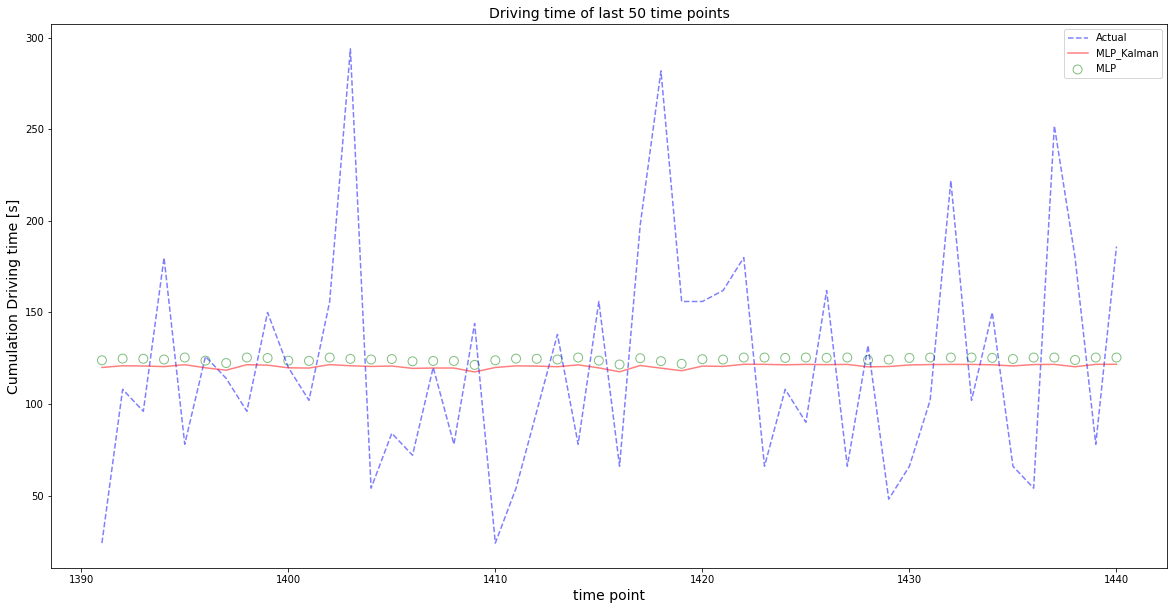

time: 357 ms (started: 2021-01-14 14:02:41 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(comb_result['Actual'][-50:],label = "Actual",linestyle='--',color='b',alpha=0.5)
plt.scatter(x = comb_result.index[-50:], y = comb_result['MLP'][-50:],label = 'MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_result['MLP_Kalman'][-50:],label = "MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'Cumulation Driving time [s]', fontsize=14)
plt.xlabel('time point', fontsize=14)

plt.title('Driving time of last 50 time points', fontsize = 14)

plt.legend()
#plt.plot(y_test.index[:50], s, '.-', color='red', label='Real values', alpha=0.5)

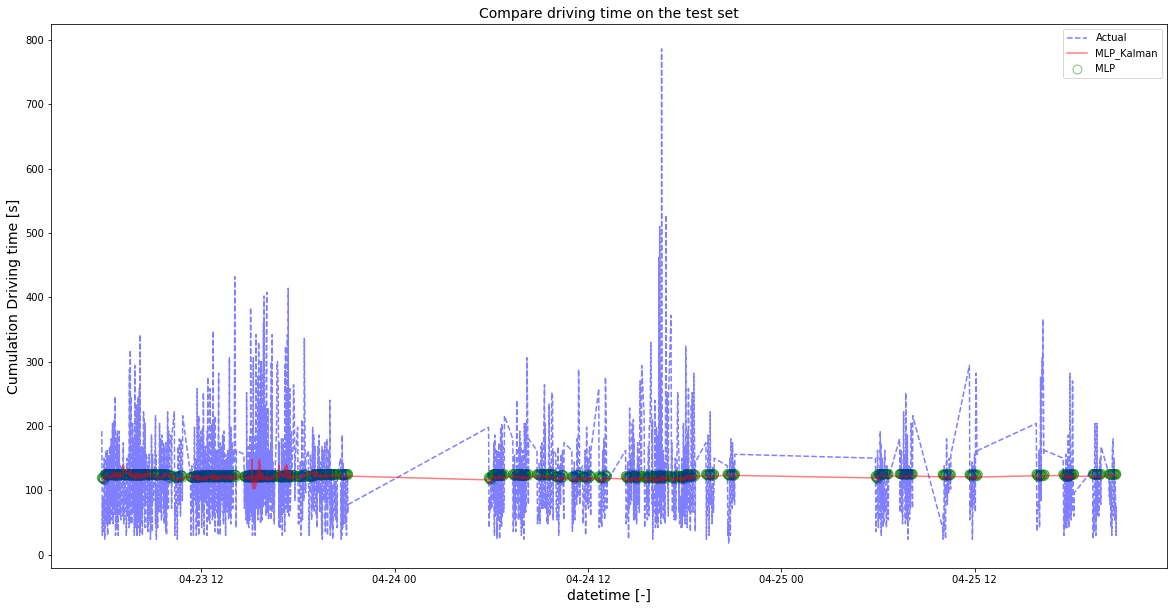

time: 476 ms (started: 2021-01-14 14:02:42 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(comb_result.sort_values(by='Date time')['Date time'],comb_result.sort_values(by='Date time')['Actual'],label = "Actual",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_result.sort_values(by='Date time')['Date time'],y=comb_result.sort_values(by='Date time')['MLP'],label = 'MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_result.sort_values(by='Date time')['Date time'],comb_result.sort_values(by='Date time')['MLP_Kalman'],label = "MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'Cumulation Driving time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.title('Compare driving time on the test set', fontsize = 14)

plt.legend()
#plt.plot(y_test.index[:50], s, '.-', color='red', label='Real values', alpha=0.5)

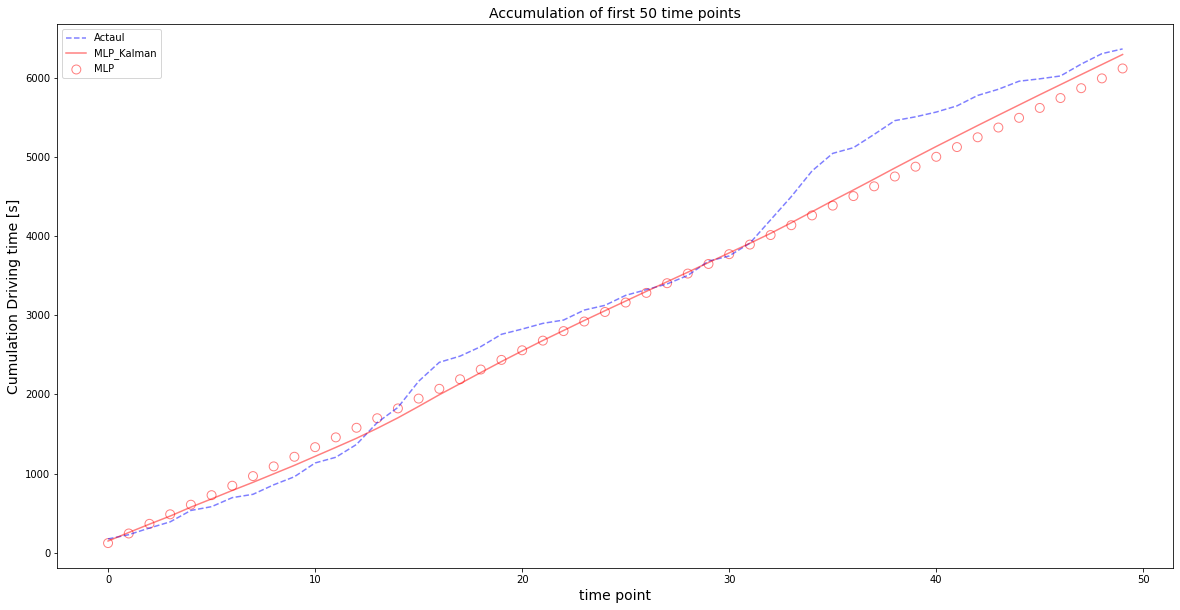

time: 361 ms (started: 2021-01-14 14:02:42 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(comb_result.index[:50],comb_result['Actual_cum'][:50],label = "Actaul",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_result.index[:50],y=comb_result['MLP_cum'][:50],label = 'MLP',s=80, facecolors='none', edgecolors='r',alpha=0.5)
plt.plot(comb_result.index[:50],comb_result['MLP_Kalman_cum'][:50],label = "MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'Cumulation Driving time [s]', fontsize=14)
plt.xlabel('time point', fontsize=14)

plt.title('Accumulation of first 50 time points', fontsize = 14)

plt.legend()
#plt.plot(y_test.index[:50], s, '.-', color='red', label='Real values', alpha=0.5)

In [ ]:
#comb_result.loc[comb_result['Path'] == 'U Alter Teichweg|Habichtstraße (Mitte)']
comb_result

,Time,Date time,Path,Actual,MLP,Actual_cum,MLP_cum,MLP_Kalman,MLP_Kalman_cum,Actual_trip_cum,MLP_trip_cum,MLP_Kalman_trip_cum
0,2019-04-23 15:09:00,2019-04-23 15:09:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,174.0,121.648451,174.0,121.648451,147.824226,147.824226,174,121,147
1,2019-04-23 15:11:00,2019-04-23 15:11:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),54.0,121.315331,228.0,242.963782,107.602145,255.426371,228,242,255
2,2019-04-23 15:12:00,2019-04-23 15:12:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,84.0,122.158887,312.0,365.122669,105.762572,361.188943,312,365,361
3,2019-04-23 15:14:00,2019-04-23 15:14:00,Moltrechtweg|Brabandstraße,78.0,120.377157,390.0,485.499826,102.063937,463.252880,390,485,463
4,2019-04-23 15:15:00,2019-04-23 15:15:00,Brabandstraße|Hindenburgstraße,144.0,121.039073,534.0,606.538898,112.657081,575.909961,534,606,575
...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2019-04-25 07:41:00,2019-04-25 07:41:00,U Habichtstraße|Habichtstraße (Mitte),54.0,125.380412,167832.0,176547.615420,121.539638,173351.193132,1614,1876,1820
1437,2019-04-25 07:43:00,2019-04-25 07:43:00,Habichtstraße (Mitte)|U Alter Teichweg,252.0,125.380394,168084.0,176672.995814,121.632949,173472.826081,1866,2002,1941
1438,2019-04-25 07:46:00,2019-04-25 07:46:00,U Alter Teichweg|U Straßburger Straße,180.0,124.038584,168264.0,176797.034398,120.335206,173593.161287,2046,2126,2062
1439,2019-04-25 07:48:00,2019-04-25 07:48:00,U Straßburger Straße|Wandsbeker Allee,78.0,125.380412,168342.0,176922.414811,121.649294,173714.810581,2124,2251,2183


time: 49.4 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
data

,Driving_time_s,Node A to Node B_AK Barmbek|Hartzloh,Node A to Node B_Alsterkrugchaussee (Mitte)|Moltrechtweg,Node A to Node B_Brabandstraße|Hindenburgstraße,Node A to Node B_Habichtsplatz|U Habichtstraße,Node A to Node B_Habichtstraße (Mitte)|U Alter Teichweg,Node A to Node B_Hartzloh|Habichtsplatz,Node A to Node B_Hindenburgstraße|U Alsterdorf,Node A to Node B_Kapstadtring|S Rübenkamp,Node A to Node B_Lufthansa-Basis (Haupteingang)|Obenhauptstraße,Node A to Node B_Manilabrücke|Kapstadtring,Node A to Node B_Moltrechtweg|Brabandstraße,Node A to Node B_Obenhauptstraße|Alsterkrugchaussee (Mitte),Node A to Node B_S Rübenkamp|AK Barmbek,Node A to Node B_Sydneystraße|Manilabrücke,Node A to Node B_U Alsterdorf|Sydneystraße,Node A to Node B_U Alter Teichweg|U Straßburger Straße,Node A to Node B_U Habichtstraße|Habichtstraße (Mitte),Node A to Node B_U Straßburger Straße|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Wandsbek Markt,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4,timeofday_5
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-01 15:09:00,168.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2019-04-01 15:11:00,66.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2019-04-01 15:12:00,126.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2019-04-01 15:14:00,48.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2019-04-01 15:15:00,120.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-25 07:41:00,54.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2019-04-25 07:43:00,252.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2019-04-25 07:46:00,180.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


time: 59.6 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
#data.loc[data['Node A to Node B_U Alter Teichweg|Habichtstraße (Mitte)']==1]

time: 913 µs (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
comb_result['Path'].unique()

['Lufthansa-Basis (Haupteingang)|Obenhauptstraße', 'Obenhauptstraße|Alsterkrugchaussee (Mitte)', 'Alsterkrugchaussee (Mitte)|Moltrechtweg', 'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße', ..., 'U Habichtstraße|Habichtstraße (Mitte)', 'Habichtstraße (Mitte)|U Alter Teichweg', 'U Alter Teichweg|U Straßburger Straße', 'U Straßburger Straße|Wandsbeker Allee', 'Wandsbeker Allee|U Wandsbek Markt']
Length: 19
Categories (19, object): ['Lufthansa-Basis (Haupteingang)|Obenhauptstraße', 'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
                          'Alsterkrugchaussee (Mitte)|Moltrechtweg', 'Moltrechtweg|Brabandstraße', ...,
                          'Habichtstraße (Mitte)|U Alter Teichweg', 'U Alter Teichweg|U Straßburger Straße',
                          'U Straßburger Straße|Wandsbeker Allee', 'Wandsbeker Allee|U Wandsbek Markt']

time: 7.17 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
comb_result.groupby( 'Path' ).mean()

In [ ]:
def rmse( g ):
    rmse_MLP = np.sqrt( mean_squared_error(g['Actual'], g['MLP'] ))
    rmse_MLP_Kalman = np.sqrt( mean_squared_error( g['Actual'], g['MLP_Kalman'] ) )
    rmse_MLP_trip = np.sqrt( mean_squared_error(g['Actual_trip_cum'], g['MLP_trip_cum'] ))
    rmse_MLP_Kalman_trip = np.sqrt( mean_squared_error( g['Actual_trip_cum'], g['MLP_Kalman_trip_cum'] ) )
    return pd.Series( dict(  rmse_MLP= rmse_MLP, rmse_MLP_Kalman = rmse_MLP_Kalman, rmse_MLP_trip= rmse_MLP_trip, rmse_MLP_Kalman_trip = rmse_MLP_Kalman_trip ) )

comb_result_rmse = comb_result.groupby( 'Path' ).apply( rmse ).reset_index()
comb_result_rmse

,Path,rmse_MLP,rmse_MLP_Kalman,rmse_MLP_trip,rmse_MLP_Kalman_trip
0,AK Barmbek|Hartzloh,54.192815,51.554480,300.273631,275.792144
1,Alsterkrugchaussee (Mitte)|Moltrechtweg,47.191577,46.057750,87.179337,85.355295
2,Brabandstraße|Hindenburgstraße,32.650384,31.702310,140.399664,133.376742
3,Habichtsplatz|U Habichtstraße,83.979784,83.555356,297.972182,272.582846
4,Habichtstraße (Mitte)|U Alter Teichweg,164.411433,165.273009,317.473331,304.685429
5,Hartzloh|Habichtsplatz,42.944146,44.480436,278.821544,252.946055
6,Hindenburgstraße|U Alsterdorf,58.352788,56.370687,180.763003,170.707737
7,Kapstadtring|S Rübenkamp,35.143409,33.766336,300.797099,280.658858
8,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,69.493528,70.762619,69.915645,71.176486
9,Manilabrücke|Kapstadtring,43.631227,41.651137,285.130395,268.000516


time: 72.6 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
comb_result_rmse['Path'] = comb_result_rmse['Path'] .astype("category")
comb_result_rmse['Path'] .cat.set_categories(route_unique, inplace=True)

print(comb_result_rmse['Path'])


0                                AK Barmbek|Hartzloh
1            Alsterkrugchaussee (Mitte)|Moltrechtweg
2                     Brabandstraße|Hindenburgstraße
3                      Habichtsplatz|U Habichtstraße
4             Habichtstraße (Mitte)|U Alter Teichweg
5                             Hartzloh|Habichtsplatz
6                      Hindenburgstraße|U Alsterdorf
7                           Kapstadtring|S Rübenkamp
8     Lufthansa-Basis (Haupteingang)|Obenhauptstraße
9                          Manilabrücke|Kapstadtring
10                        Moltrechtweg|Brabandstraße
11        Obenhauptstraße|Alsterkrugchaussee (Mitte)
12                            S Rübenkamp|AK Barmbek
13                         Sydneystraße|Manilabrücke
14                         U Alsterdorf|Sydneystraße
15             U Alter Teichweg|U Straßburger Straße
16             U Habichtstraße|Habichtstraße (Mitte)
17             U Straßburger Straße|Wandsbeker Allee
18                 Wandsbeker Allee|U Wandsbek

In [ ]:
comb_result_rmse = comb_result_rmse.sort_values(["Path"]).reset_index()
comb_result_rmse

,index,Path,rmse_MLP,rmse_MLP_Kalman,rmse_MLP_trip,rmse_MLP_Kalman_trip
0,8,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,69.493528,70.762619,69.915645,71.176486
1,11,Obenhauptstraße|Alsterkrugchaussee (Mitte),76.766466,74.936101,57.030347,56.789547
2,1,Alsterkrugchaussee (Mitte)|Moltrechtweg,47.191577,46.057750,87.179337,85.355295
3,10,Moltrechtweg|Brabandstraße,54.341316,52.091159,127.659343,122.591963
4,2,Brabandstraße|Hindenburgstraße,32.650384,31.702310,140.399664,133.376742
5,6,Hindenburgstraße|U Alsterdorf,58.352788,56.370687,180.763003,170.707737
6,14,U Alsterdorf|Sydneystraße,28.491483,29.874551,171.487571,160.377187
7,13,Sydneystraße|Manilabrücke,83.846092,81.209694,248.898574,233.821598
8,9,Manilabrücke|Kapstadtring,43.631227,41.651137,285.130395,268.000516
9,7,Kapstadtring|S Rübenkamp,35.143409,33.766336,300.797099,280.658858


time: 26.1 ms (started: 2021-01-14 14:02:43 +00:00)


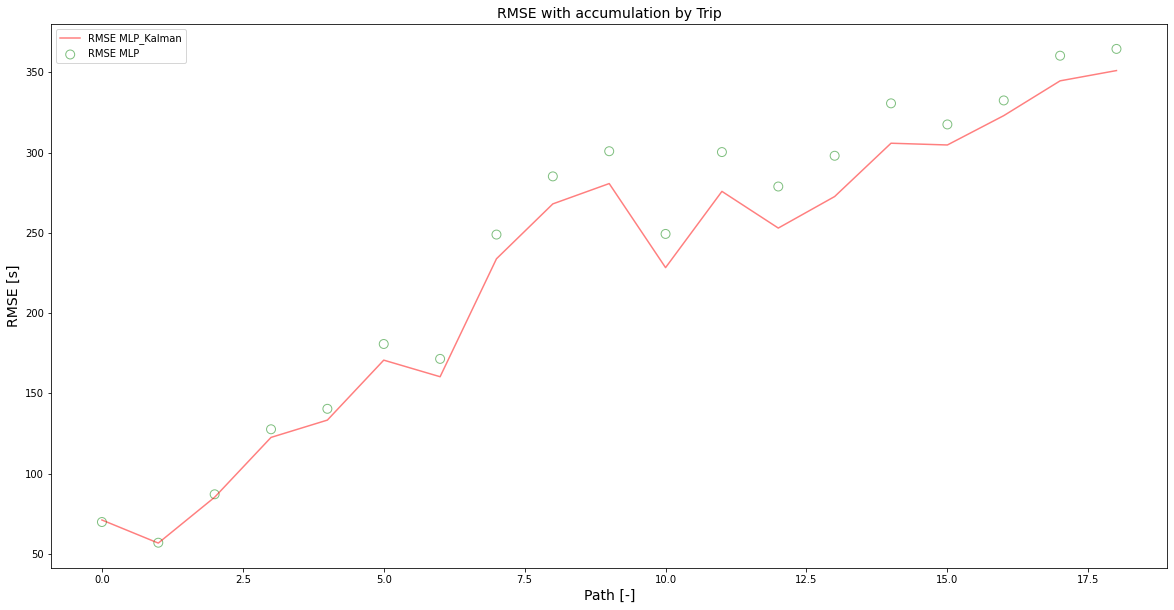

time: 328 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_trip'],label = "RMSE MLP",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_result_rmse.index,y=comb_result_rmse['rmse_MLP_trip'],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_Kalman_trip'],label = "RMSE MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'RMSE [s]', fontsize=14)
plt.xlabel('Path [-]', fontsize=14)

plt.title('RMSE with accumulation by Trip', fontsize = 14)

plt.legend()

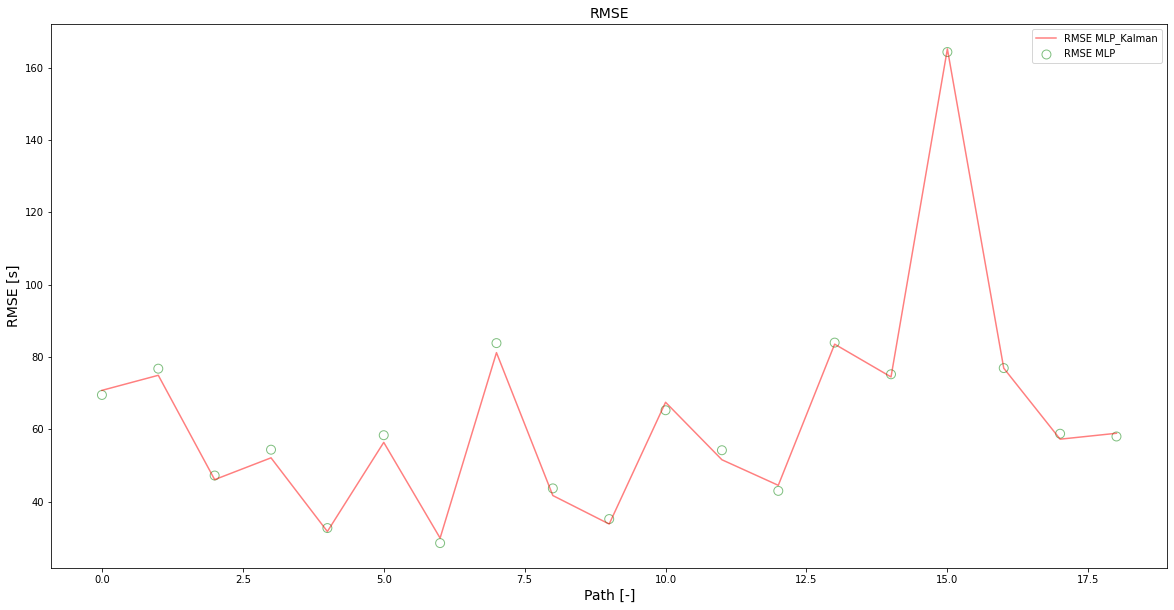

time: 330 ms (started: 2021-01-14 14:02:43 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_trip'],label = "RMSE MLP",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_result_rmse.index,y=comb_result_rmse['rmse_MLP'],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_Kalman'],label = "RMSE MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'RMSE [s]', fontsize=14)
plt.xlabel('Path [-]', fontsize=14)

plt.title('RMSE', fontsize = 14)

plt.legend()

## **Run Kalman filter by tour**

Same procedure as above but running tour by tour.

### Preparing data

In [ ]:
comb_kf = comb_result[['Date time','Path', 'Actual', 'Actual_trip_cum', 'MLP', 'MLP_trip_cum']]
comb_kf[:50]

### Implement Kalman filter

The filtering procedure is outlined as follows.





1.   set $\hat X^-_0 = \begin{pmatrix}
  \hat t_0 \\ \hat s_0 
 \end{pmatrix}  =  \begin{pmatrix}
  \hat t_0 \\ 0 
 \end{pmatrix} $ 
 ; $t_0$ is the total travel time predicted from MLP of that trip. $s_0$ is the travel time predicted from MLP from the origin to the time point $k$ therefore $s_0$ is zero.
2.   set covariance matrix $p_0 = \begin{pmatrix}
  1 & 0 \\
  0 & 1 
 \end{pmatrix} $

3. predict State variable $ \hat X^-_k = F \hat X_{k-1} + T_{k-1, k} \begin{pmatrix}
  -1 \\ 1
 \end{pmatrix}
 = \begin{pmatrix}
  1 & 0 \\ 0 & 1
 \end{pmatrix}
  \hat X_{k-1} + T_{k-1, k} \begin{pmatrix}
  -1 \\ 1
 \end{pmatrix}$
 ; $T_{k-1, k}$ is the travel time predicted from MLP from node $k-1$ to $k$

4. calculate Covariance $P^-_k = F P_{k-1} F^T + Q_{k-1}$ where $Q_{k-1}$ is the process noise.

5. calculate Kalman gain $K_k = P^-_kH (HP^-_kH^T + R)^{-1}$ where $ H = \begin{pmatrix}
  0 & 1
 \end{pmatrix} $ and $R$ is the measure noise

6. update State variable $\hat X_k = \hat X^-_k  +K_k(z_k - H \hat X^-_k) $ ; $z_k$ is the actual driving time from the original $k = 0$ to time point $k$

7. if $k$ is the destination time point, finish the process. Otherwise continue.

8. update Covariance $P_k = P^-_k - K_k H P^-_k$

9. repeat from 3.




In [ ]:
!pip install filterpy==1.1.0
#from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
dt = 0.
R_var = 1. #measure noise variance
Q_var = 1. #process noise variance
#x = np.array([[0, 0]]).T #initial of x^_0 = (t[0], s[0]).T
#P = np.diag([1, 1]) #initial covariance
F = np.array([[1, dt], #transformation matrix
              [0,  1]])
H = np.array([[0., 1.]]) #measurement function
R = np.array([[R_var]]) #measure noise
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var) #process noise
u = np.array([[-1, 1]]).T #the control input

time: 2.75 s (started: 2021-01-14 14:02:44 +00:00)


In [ ]:
route_unique[0]

'Lufthansa-Basis (Haupteingang)|Obenhauptstraße'

time: 5.77 ms (started: 2021-01-14 14:02:46 +00:00)


In [ ]:
end_trip_pred = []
for i in range(len(comb_kf['Path'])):
  if (i != 0) and (comb_kf['Path'][i] == route_unique[0]):
    end_trip_pred.append(comb_kf['MLP_trip_cum'][(i-1)])
  elif i == len(comb_kf['Path'])-1:
    end_trip_pred.append(comb_kf['MLP_trip_cum'][(i)])
end_trip_pred

In [ ]:
len(end_trip_pred)

76

time: 2.87 ms (started: 2021-01-14 14:02:46 +00:00)


In [ ]:
comb_kf[comb_kf['Path'] == route_unique[0]].shape

(76, 6)

time: 9.42 ms (started: 2021-01-14 14:02:46 +00:00)


In [ ]:
''' # collect data after update process
from numpy import dot
from scipy.linalg import inv


xs, cov = [], []
pos = 0
for z in range(len(comb_kf['Actual_trip_cum'])):
    if comb_kf['Path'][z] == route_unique[0]:
      x = np.array([[end_trip_pred[pos], 0]]).T #initial of x^_0 = (t[0], s[0]).T
      pos +=1
      P = np.diag([1, 1]) #initial covariance
      #print(pos, x)
    B = comb_kf['MLP'][z]
    # predict
    x = dot(F, x) + dot(B, u)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    #print(dot(K, y))
    y = comb_kf['Actual_trip_cum'][z] - dot(H, x)
    x += dot(K, y)
    print(x)
    P = P - dot(K, H).dot(P)
    
    xs.append(x.flatten())
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
'''

In [ ]:
from numpy import dot
from scipy.linalg import inv


xs, cov = [], []
pos = 0
for z in range(len(comb_kf['Actual_trip_cum'])):
    if comb_kf['Path'][z] == route_unique[0]:
      x = np.array([[end_trip_pred[pos], 0]]).T #initial of x^_0 = (t[0], s[0]).T
      pos +=1
      P = np.diag([1, 1]) #initial covariance
      #print(pos, x)
    B = comb_kf['MLP'][z]
    # predict
    x = dot(F, x) + dot(B, u)
    xs.append(x.flatten())
    print("xt:", x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    #print(dot(K, y))
    y = comb_kf['Actual_trip_cum'][z] - dot(H, x)
    x += dot(K, y)
    print("xs:", x)
    P = P - dot(K, H).dot(P)
    
    #xs.append(x.flatten())
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)

In [ ]:
xs

array([[ 2.19235155e+03,  1.21648451e+02],
       [ 2.07103622e+03,  2.69139556e+02],
       [ 1.94887733e+03,  3.77585258e+02],
       ...,
       [ 2.49939330e+02,  2.02004823e+03],
       [ 1.24558918e+02,  2.14687040e+03],
       [-8.21494460e-01,  2.27104711e+03]])

time: 6.63 ms (started: 2021-01-14 14:02:50 +00:00)


### Show results

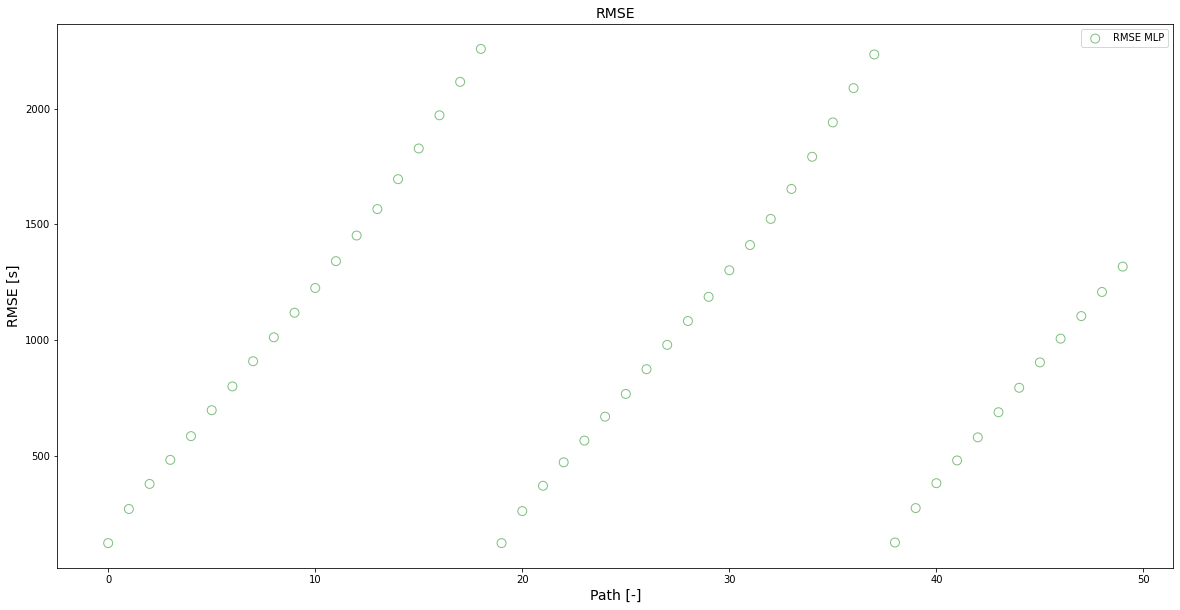

time: 300 ms (started: 2021-01-14 14:02:50 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_trip'],label = "RMSE MLP",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_result.index[:50],y=xs[:,1][:50],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
#plt.scatter(x=comb_result.index[:50],y=xt[:,1][:50],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='b',alpha=0.5)
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_Kalman'],label = "RMSE MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'RMSE [s]', fontsize=14)
plt.xlabel('Path [-]', fontsize=14)

plt.title('RMSE', fontsize = 14)

plt.legend()

#### Arrange results table

In [ ]:
xs_sep = []
a = 0
for i in range(len(comb_kf['Path'])):
    if comb_kf['Path'][i] == route_unique[0]:
      a = xs[:, 1][i]
      xs_sep.append(a)
      #print(a)
    else:
      a = xs[:, 1][i] - a
      xs_sep.append(a)
      #print('xxx',a)
      a = xs[:, 1][i]

xs_sep


In [ ]:
'''
xt_sep = []
a = 0
for i in range(len(comb_kf['Path'])):
    if comb_kf['Path'][i] == route_unique[0]:
      a = xt[:, 1][i]
      xt_sep.append(a)
      #print(a)
    else:
      a = xt[:, 1][i] - a
      xt_sep.append(a)
      #print('xxx',a)
      a = xt[:, 1][i]

xt_sep
'''

"\nxt_sep = []\na = 0\nfor i in range(len(comb_kf['Path'])):\n    if comb_kf['Path'][i] == route_unique[0]:\n      a = xt[:, 1][i]\n      xt_sep.append(a)\n      #print(a)\n    else:\n      a = xt[:, 1][i] - a\n      xt_sep.append(a)\n      #print('xxx',a)\n      a = xt[:, 1][i]\n\nxt_sep\n"

time: 4.3 ms (started: 2021-01-14 14:02:51 +00:00)


In [ ]:
#comb_kf = pd.DataFrame({'Date time': y_test.index, 'Path': df_proceeded['Node A to Node B'][split_index_test:], 'Actual': y_true[:,0], 'Actual_cum': zs_ext, 'MLP': y_pred[:,0], 'MLP_cum': s_ext, 'MLP_Kalman': xs_ext_sep, 'MLP_Kalman_cum': xs_ext}).reset_index()

comb_kf['MLP_Kalman'] = xs_sep
comb_kf['MLP_Kalman_trip_cum'] = xs[:,1]
comb_kf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date time,Path,Actual,Actual_trip_cum,MLP,MLP_trip_cum,MLP_Kalman,MLP_Kalman_trip_cum
0,2019-04-23 15:09:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,174.0,174,121.648451,121,121.648451,121.648451
1,2019-04-23 15:11:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),54.0,228,121.315331,242,147.491105,269.139556
2,2019-04-23 15:12:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,84.0,312,122.158887,365,108.445701,377.585258
3,2019-04-23 15:14:00,Moltrechtweg|Brabandstraße,78.0,390,120.377157,485,103.980843,481.566100
4,2019-04-23 15:15:00,Brabandstraße|Hindenburgstraße,144.0,534,121.039073,606,102.725853,584.291953
...,...,...,...,...,...,...,...,...
1436,2019-04-25 07:41:00,U Habichtstraße|Habichtstraße (Mitte),54.0,1614,125.380412,1876,118.402453,1783.071842
1437,2019-04-25 07:43:00,Habichtstraße (Mitte)|U Alter Teichweg,252.0,1866,125.380394,2002,114.813404,1897.885246
1438,2019-04-25 07:46:00,U Alter Teichweg|U Straßburger Straße,180.0,2046,124.038584,2126,122.162981,2020.048227
1439,2019-04-25 07:48:00,U Straßburger Straße|Wandsbeker Allee,78.0,2124,125.380412,2251,126.822178,2146.870405


time: 42.9 ms (started: 2021-01-14 14:02:51 +00:00)


In [ ]:
#comb_kf = pd.DataFrame({'Date time': y_test.index, 'Path': df_proceeded['Node A to Node B'][split_index_test:], 'Actual': y_true[:,0], 'Actual_cum': zs_ext, 'MLP': y_pred[:,0], 'MLP_cum': s_ext, 'MLP_Kalman': xs_ext_sep, 'MLP_Kalman_cum': xs_ext}).reset_index()
'''
comb_kf['MLP_Kalman_xt'] = xt_sep
comb_kf['MLP_Kalman_trip_cum_xt'] = xt[:,1]
comb_kf
'''

"\ncomb_kf['MLP_Kalman_xt'] = xt_sep\ncomb_kf['MLP_Kalman_trip_cum_xt'] = xt[:,1]\ncomb_kf\n"

time: 3.09 ms (started: 2021-01-14 14:02:51 +00:00)


#### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
#RMSE
print('Individual')
print('RMSE of MLP:', np.sqrt(mean_squared_error(comb_kf['Actual'],comb_kf['MLP'])))
print('RMSE of MLP with Kalman filter:',np.sqrt(mean_squared_error(comb_kf['Actual'],comb_kf['MLP_Kalman']))) #get better results when tune with Kalman filter
#print('RMSE of MLP with Kalman filter xt:',np.sqrt(mean_squared_error(comb_kf['Actual'],comb_kf['MLP_Kalman_xt'])))

print('Accumulation by trip')
print('RMSE of MLP:', np.sqrt(mean_squared_error(comb_kf['Actual_trip_cum'],comb_kf['MLP_trip_cum'])))
print('RMSE of MLP with Kalman filter:',np.sqrt(mean_squared_error(comb_kf['Actual_trip_cum'],comb_kf['MLP_Kalman_trip_cum']))) #get better results when tune with Kalman filter
#print('RMSE of MLP with Kalman filter xt:',np.sqrt(mean_squared_error(comb_kf['Actual_trip_cum'],comb_kf['MLP_Kalman_trip_cum_xt'])))

Individual
RMSE of MLP: 69.94142369648091
RMSE of MLP with Kalman filter: 70.10554225703328
Accumulation by trip
RMSE of MLP: 256.41528436679613
RMSE of MLP with Kalman filter: 169.1637191694092
time: 25 ms (started: 2021-01-14 14:02:51 +00:00)


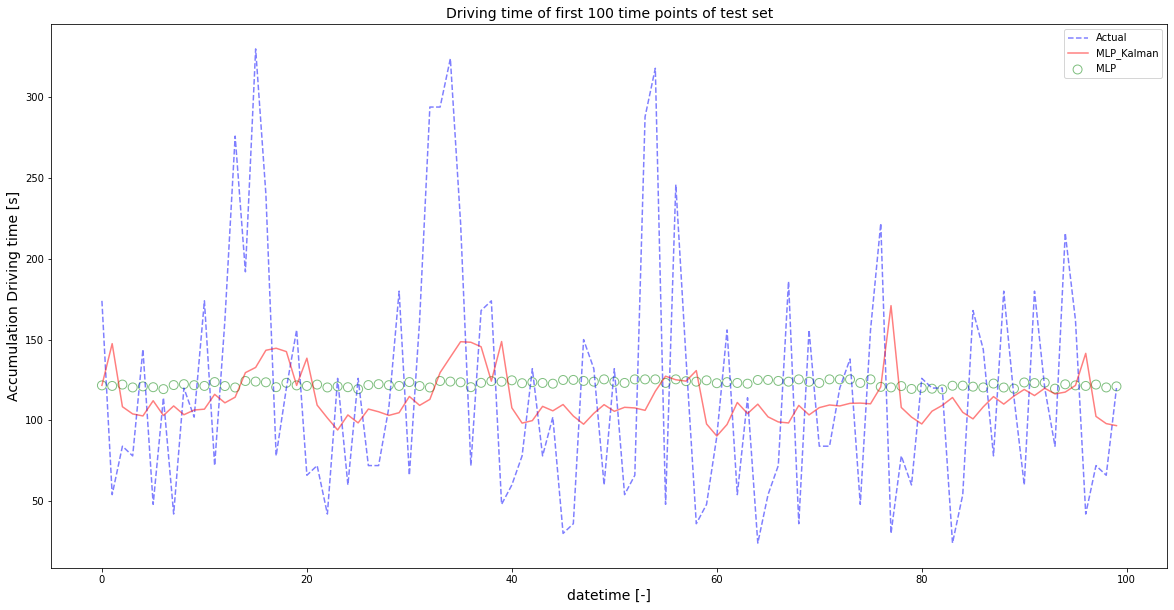

time: 360 ms (started: 2021-01-14 14:02:51 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(comb_kf.index[:100],comb_kf['Actual'][:100],label = "Actual",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_kf.index[:100],y=comb_kf['MLP'][:100],label = 'MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_kf.index[:100],comb_kf['MLP_Kalman'][:100],label = "MLP_Kalman",linestyle='-',color='r',alpha=0.5)
#plt.plot(comb_kf.index[:100],comb_kf['MLP_Kalman_xt'][:100],label = "MLP_Kalman_xt",linestyle='-',color='k',alpha=0.5)

plt.ylabel(r'Accumulation Driving time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.title('Driving time of first 100 time points of test set', fontsize = 14)

plt.legend()

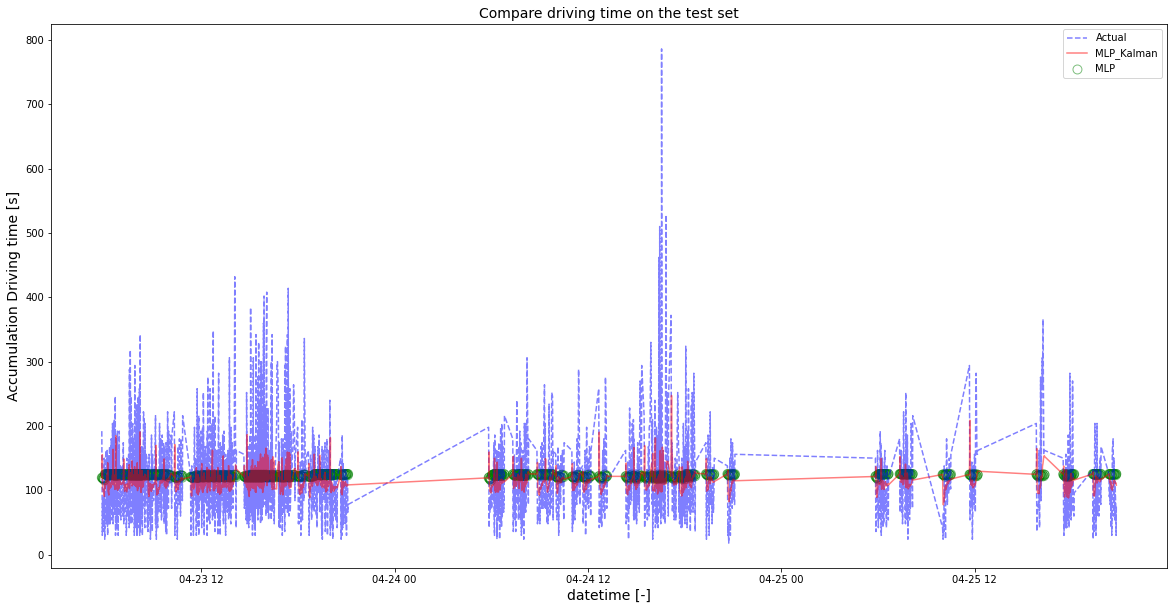

time: 476 ms (started: 2021-01-14 14:02:51 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(comb_kf.sort_values(by='Date time')['Date time'],comb_kf.sort_values(by='Date time')['Actual'],label = "Actual",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_kf.sort_values(by='Date time')['Date time'],y=comb_kf.sort_values(by='Date time')['MLP'],label = 'MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_kf.sort_values(by='Date time')['Date time'],comb_kf.sort_values(by='Date time')['MLP_Kalman'],label = "MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'Accumulation Driving time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.title('Compare driving time on the test set', fontsize = 14)

plt.legend()

In [ ]:
comb_kf.groupby('Path').mean()

,Actual,Actual_trip_cum,MLP,MLP_trip_cum,MLP_Kalman,MLP_Kalman_trip_cum
Path,,,,,,
AK Barmbek|Hartzloh,72.240000,1186.640000,124.302160,1470.760000,115.266805,1338.091070
Alsterkrugchaussee (Mitte)|Moltrechtweg,87.315789,312.868421,122.848573,368.473684,107.125906,379.846537
Brabandstraße|Hindenburgstraße,108.473684,492.631579,121.954568,611.776316,101.847091,586.542369
Habichtsplatz|U Habichtstraße,124.894737,1455.394737,121.497369,1709.736842,113.309376,1557.722682
Habichtstraße (Mitte)|U Alter Teichweg,248.289474,1828.026316,124.283047,1958.921053,118.295928,1794.067869
Hartzloh|Habichtsplatz,149.440000,1336.080000,122.401173,1593.080000,110.751091,1448.842161
Hindenburgstraße|U Alsterdorf,75.394737,568.026316,122.164557,734.026316,106.512758,693.055127
Kapstadtring|S Rübenkamp,106.578947,935.289474,123.021463,1223.394737,104.729626,1116.358526
Lufthansa-Basis (Haupteingang)|Obenhauptstraße,176.526316,176.500000,123.016741,122.486842,123.016741,123.016741


time: 34.2 ms (started: 2021-01-14 14:02:52 +00:00)


In [ ]:
'''
def rmse( g ):
    rmse_MLP = np.sqrt( mean_squared_error(g['Actual'], g['MLP'] ))
    rmse_MLP_Kalman = np.sqrt( mean_squared_error( g['Actual'], g['MLP_Kalman'] ) )
    rmse_MLP_trip = np.sqrt( mean_squared_error(g['Actual_trip_cum'], g['MLP_trip_cum'] ))
    rmse_MLP_Kalman_trip = np.sqrt( mean_squared_error( g['Actual_trip_cum'], g['MLP_Kalman_trip_cum'] ) )
    return pd.Series( dict(  rmse_MLP= rmse_MLP, rmse_MLP_Kalman = rmse_MLP_Kalman, rmse_MLP_trip= rmse_MLP_trip, rmse_MLP_Kalman_trip = rmse_MLP_Kalman_trip ) )
'''
comb_kf_rmse = comb_kf.groupby( 'Path' ).apply( rmse ).reset_index()
comb_kf_rmse

,Path,rmse_MLP,rmse_MLP_Kalman,rmse_MLP_trip,rmse_MLP_Kalman_trip
0,AK Barmbek|Hartzloh,54.192815,45.345443,300.273631,160.452228
1,Alsterkrugchaussee (Mitte)|Moltrechtweg,47.191577,36.235015,87.179337,79.403307
2,Brabandstraße|Hindenburgstraße,32.650384,31.496945,140.399664,103.304954
3,Habichtsplatz|U Habichtstraße,83.979784,83.601218,297.972182,154.139312
4,Habichtstraße (Mitte)|U Alter Teichweg,164.411433,165.110617,317.473331,241.043064
5,Hartzloh|Habichtsplatz,42.944146,50.889378,278.821544,129.082880
6,Hindenburgstraße|U Alsterdorf,58.352788,48.883994,180.763003,131.815492
7,Kapstadtring|S Rübenkamp,35.143409,32.775770,300.797099,186.383007
8,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,69.493528,69.493528,69.915645,69.492601
9,Manilabrücke|Kapstadtring,43.631227,30.102334,285.130395,188.727591


time: 74.1 ms (started: 2021-01-14 14:02:52 +00:00)


In [ ]:
comb_kf_rmse['Path'] = comb_kf_rmse['Path'] .astype("category")
comb_kf_rmse['Path'] .cat.set_categories(route_unique, inplace=True)

print(comb_kf_rmse['Path'])
comb_kf_rmse = comb_kf_rmse.sort_values(["Path"]).reset_index()
comb_kf_rmse

0                                AK Barmbek|Hartzloh
1            Alsterkrugchaussee (Mitte)|Moltrechtweg
2                     Brabandstraße|Hindenburgstraße
3                      Habichtsplatz|U Habichtstraße
4             Habichtstraße (Mitte)|U Alter Teichweg
5                             Hartzloh|Habichtsplatz
6                      Hindenburgstraße|U Alsterdorf
7                           Kapstadtring|S Rübenkamp
8     Lufthansa-Basis (Haupteingang)|Obenhauptstraße
9                          Manilabrücke|Kapstadtring
10                        Moltrechtweg|Brabandstraße
11        Obenhauptstraße|Alsterkrugchaussee (Mitte)
12                            S Rübenkamp|AK Barmbek
13                         Sydneystraße|Manilabrücke
14                         U Alsterdorf|Sydneystraße
15             U Alter Teichweg|U Straßburger Straße
16             U Habichtstraße|Habichtstraße (Mitte)
17             U Straßburger Straße|Wandsbeker Allee
18                 Wandsbeker Allee|U Wandsbek

,index,Path,rmse_MLP,rmse_MLP_Kalman,rmse_MLP_trip,rmse_MLP_Kalman_trip
0,8,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,69.493528,69.493528,69.915645,69.492601
1,11,Obenhauptstraße|Alsterkrugchaussee (Mitte),76.766466,104.033672,57.030347,58.090914
2,1,Alsterkrugchaussee (Mitte)|Moltrechtweg,47.191577,36.235015,87.179337,79.403307
3,10,Moltrechtweg|Brabandstraße,54.341316,40.427697,127.659343,107.876699
4,2,Brabandstraße|Hindenburgstraße,32.650384,31.496945,140.399664,103.304954
5,6,Hindenburgstraße|U Alsterdorf,58.352788,48.883994,180.763003,131.815492
6,14,U Alsterdorf|Sydneystraße,28.491483,39.983352,171.487571,104.802082
7,13,Sydneystraße|Manilabrücke,83.846092,72.605547,248.898574,170.149701
8,9,Manilabrücke|Kapstadtring,43.631227,30.102334,285.130395,188.727591
9,7,Kapstadtring|S Rübenkamp,35.143409,32.775770,300.797099,186.383007


time: 33.1 ms (started: 2021-01-14 14:02:52 +00:00)


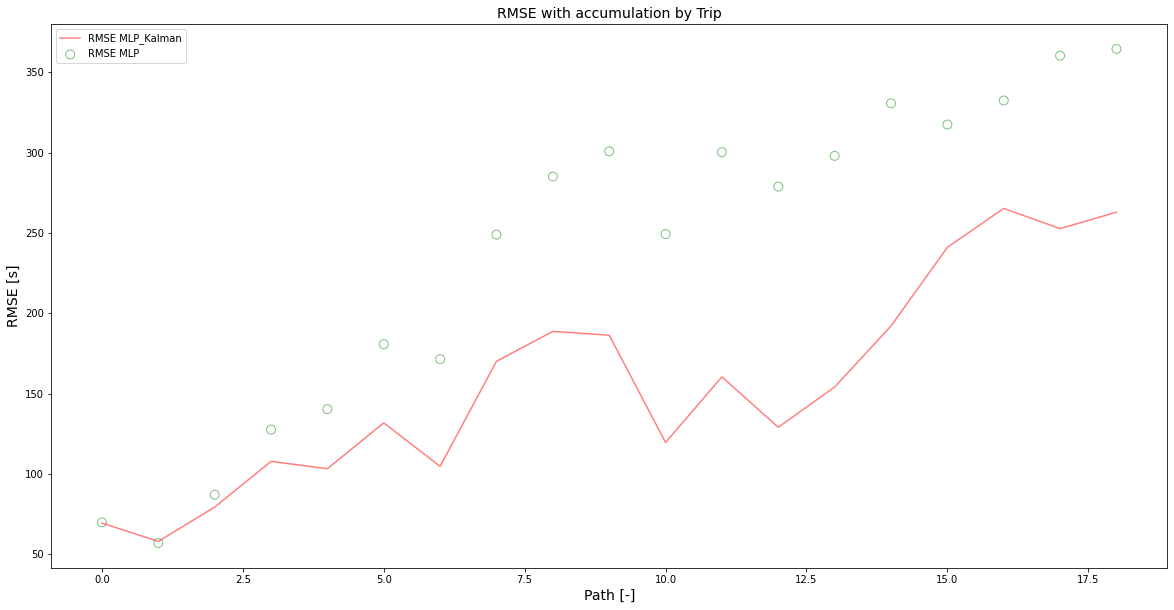

time: 340 ms (started: 2021-01-14 14:02:52 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_trip'],label = "RMSE MLP",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_kf_rmse.index,y=comb_kf_rmse['rmse_MLP_trip'],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_kf_rmse.index,comb_kf_rmse['rmse_MLP_Kalman_trip'],label = "RMSE MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'RMSE [s]', fontsize=14)
plt.xlabel('Path [-]', fontsize=14)

plt.title('RMSE with accumulation by Trip', fontsize = 14)

plt.legend()

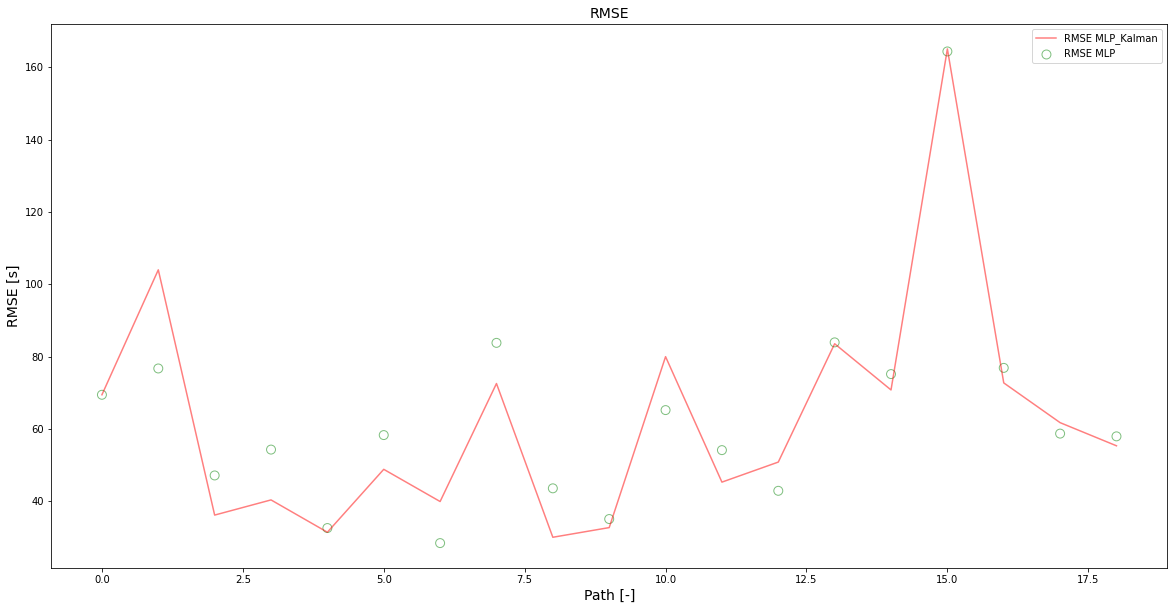

time: 516 ms (started: 2021-01-14 14:02:52 +00:00)


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(comb_result_rmse.index,comb_result_rmse['rmse_MLP_trip'],label = "RMSE MLP",linestyle='--',color='b',alpha=0.5)
plt.scatter(x=comb_kf_rmse.index,y=comb_kf_rmse['rmse_MLP'],label = 'RMSE MLP',s=80, facecolors='none', edgecolors='g',alpha=0.5)
plt.plot(comb_kf_rmse.index,comb_kf_rmse['rmse_MLP_Kalman'],label = "RMSE MLP_Kalman",linestyle='-',color='r',alpha=0.5)

plt.ylabel(r'RMSE [s]', fontsize=14)
plt.xlabel('Path [-]', fontsize=14)

plt.title('RMSE', fontsize = 14)

plt.legend()

# Export results

In [ ]:
#comb_kf.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+".csv")
#comb_kf_rmse.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+".csv")

comb_kf.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+"_m"+str(month)+".csv")
comb_kf_rmse.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+"_m"+str(month)+".csv")

time: 37.4 ms (started: 2021-01-14 14:07:03 +00:00)
